In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pylab as pylab
import pandas as pd
from operator import itemgetter

from warnings import filterwarnings

pylab.rcParams['figure.figsize'] = 5, 5
plt.rc("font", size=10)


plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

So far we have fitted our curves and doing so we have found the  best model explaining the point that we had for the fitting.

We also saw that we could choose different models according to how much the improvement obtained was worth the complexification of the model. But again we did it on the whole data that we had. We never really check how well our data was generalizing to points never seen before, or by how much the model we found was subject to outliers.

Machine learning procedures allows us to take those considerations into account. After highlighting the few caveats of the procedures we have used in the former notebook, we will introduce the foundation of machine learning way to model.

More particularly we will see that machine learning paradigm modifies the function to optimize that we have seen before by adding a penalty to covariables that generalize badly. We will also see that in machine learning procedure, the generalization is approached by fitting and evaluating mutliple times your model on subset of your data.

**Machine learning paradigm emphasizes the importance of building a general model that will be good at dealing with future unknown data points rather than being the best model on the data that we have now.**


# Table Of Content:

* [**Exploring model generalization in previous methods**](#explore-model-general)
    * [**Model sensibility to a few particular points.**](#particular-points)
    * [**How does the model change according to random data subsamples.**](#random-subsamples)
    * [**Splitting data and regularization.**](#split-reg)
* [**Regularization in the case of OLS and GLM with binomial distribution.**](#regularization)
    * [**Definition.**](#regularization-definition)
    * [**Oversimplified example on Kyphosis dataset.**](#explore-model-general)
* [**The machine learning framework.**](#ML-framework)
* [**Logistic regression and OLS regression.**](#lr-ols)
    * [**A toy model to visualize logistic regression.**](#toy-example-lr)
    * [**A new metric to evaluate your model : AUC_ROC.**](#auc_roc)
    * [**Imbalanced dataset.**](#imbalanced)
    * [**Your first classical machine learning pipeline.**](#lr-ols-pipeline)
        * [**On a classification problem using logistic regression.**](#lr-pipeline)
        * [**On a regression problem using OLS regression.**](#ols-pipeline)
    * [**What if you want to use GLM with regularization and cross fold validation, other than binomial?**](#glm)
* [**A few words on scaling.**](#scaling)
* [**A few words on leakage.**](#leakage)
* [**Exo logistic regression.**](#exo-lr)
* [**Other loss function but same regularization : Support Vector Machine.**](#svm)
    * [**Classification.**](#svm-c)
        * [**Formal introduction.**](#formal-svm-c)
        * [**Toy example to visualize SVMC.**](#toy-example-svm-c)
        * [**SVMC pipeline.**](#svm-c-pipeline)
    * [**Regression.**](#svm-r)
* [**Decision tree modeling : a new? loss function and new ways to do regularization. **](#decision-tree)
    * [**Simple decision tree for classification.**](#simple-tree-c)
        * [**Toy example to visualize decision tree.**](#toy-decision-tree)
        * [**Single decision tree pipeline.**](#single-tree-pipeline)
    * [**Random Forest in classification**](#rf-c)
    * [**Random Forest in regression**](#rf-r)
* [**Exo : regression**](#exo-regression)

# Exploring model generalization in previous methods. <a class="anchor" id="explore-model-general"></a>

## Model sensibility to a few particular points. <a class="anchor" id="particular-points"></a>

Text(0.5, 0, 'Number of pedestrians per ha per min')

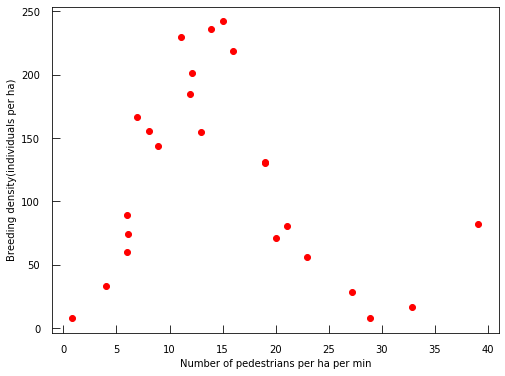

In [2]:
df=pd.read_csv("Human_nuisance.csv")
y=np.array(df["Breeding density(individuals per ha)"])
X=np.array(df["Number of pedestrians per ha per min"])

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(X,y,'ro')
ax.set_ylabel("Breeding density(individuals per ha)")
ax.set_xlabel("Number of pedestrians per ha per min")

Let's get rid of the two last points. We could argue that they look fishy since they are the only two points that go up. Maybe they are driving the cubic fit?

Text(0.5, 0, 'Number of pedestrians per ha per min')

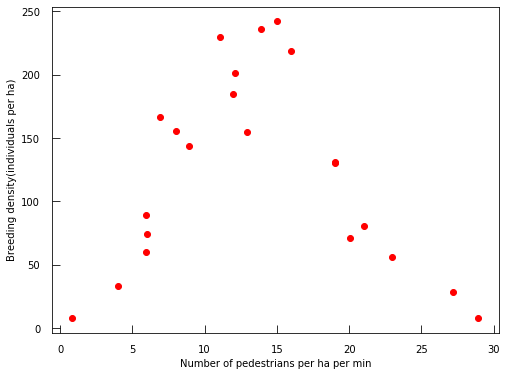

In [3]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(X[:-2],y[:-2],'ro')
ax.set_ylabel("Breeding density(individuals per ha)")
ax.set_xlabel("Number of pedestrians per ha per min")

In [4]:
import statsmodels
import statsmodels.api as sm
from utils import make_summary_tables

list_co=[]#list of covariable

df=pd.read_csv("Human_nuisance.csv")
df_nuisance=pd.DataFrame()
df_nuisance["Breeding"]=df["Breeding density(individuals per ha)"][:-2] 

ordered_loglike_multi=[]

for i in range(1,5):

    df_nuisance["N"+"^"+str(i)]=df["Number of pedestrians per ha per min"][:-2]**i
    
    list_co.append( "N"+"^"+str(i) )
    y=df_nuisance["Breeding"]
    X= df_nuisance[ list_co ]  #again making it an array 
    X = sm.add_constant(X)#the model doesn't include an intercept automatically so we creat one
    model = sm.OLS(y, X)# we create the least square fit object
    results = model.fit()#we do the actual fit
    
    result_general_df , result_fit_df = make_summary_tables( results.summary() )
   
    #print(results.summary())
    
    ordered_loglike_multi.append( [ '_'.join(list_co) , results.llf , result_fit_df])
    
ordered_loglike_multi=sorted(ordered_loglike_multi,key=itemgetter(1),reverse=True)

/home/wandrille/Installed_software/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [5]:
import scipy.stats as stats 
p_value_threshold=1#0.05## what you would consider as significant or not : i.e if you will consider
#adding the parameter or not

ordered_log_name=[v[0] for v in ordered_loglike_multi][::-1]
ordered_log_value=[v[1] for v in ordered_loglike_multi][::-1]

for i in range(1,len(ordered_log_value)):#we are going through the list of models following their order in goodness of fit
    pval=1-stats.chi2.cdf(2*(ordered_log_value[i]-ordered_log_value[i-1]),1)#calculating the pvalue
    #that compares the goodness of fit of the two models, here we are lucky the comparison always involves two models
    #that only differ by one parameter added, hence the df in the stats.chi.cdf for which the value is one.
    if pval<p_value_threshold:
        print("The log likelihood difference between model {0} and model {1} \n is associated to a P value={2}".format(ordered_log_name[i-1],ordered_log_name[i],pval))
        print()
    else:
        break

The log likelihood difference between model N^1 and model N^1_N^2 
 is associated to a P value=2.720592046090431e-07

The log likelihood difference between model N^1_N^2 and model N^1_N^2_N^3 
 is associated to a P value=0.04924437163286044

The log likelihood difference between model N^1_N^2_N^3 and model N^1_N^2_N^3_N^4 
 is associated to a P value=0.00013113805762821062



You see that the choice between quadratic and cubic is borderline here....

Let's check how the model behaves on fitting the dataset used for fitting and on those two points now missing.

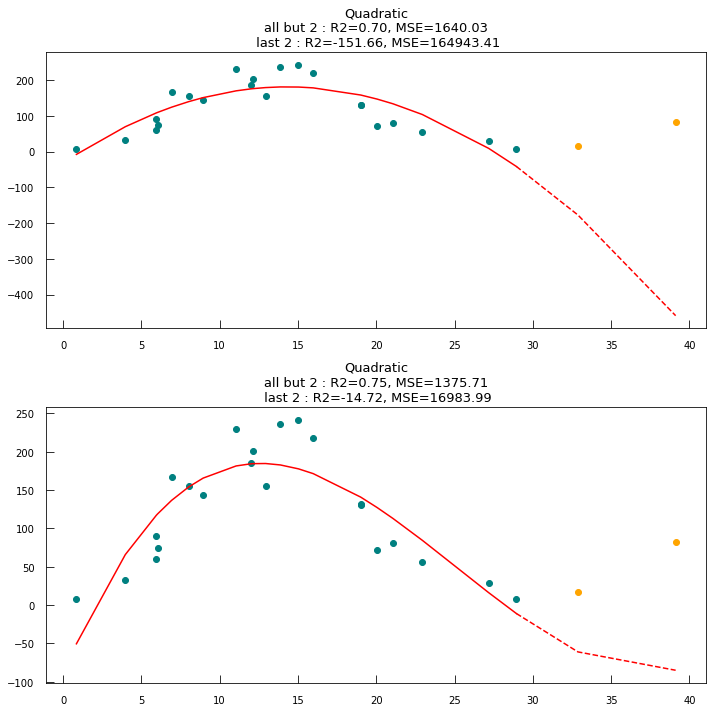

In [6]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

df=pd.read_csv("Human_nuisance.csv")
y=np.array(df["Breeding density(individuals per ha)"])
X=np.array(df["Number of pedestrians per ha per min"])

## all points but the last 2

#X_predicted_3=[-90.4906+49.1160*v-2.5977*v**2+0.0344*v**3 for v in X[:-2]]
X_predicted_3 = [ ordered_loglike_multi[1][-1].loc[ 'const' , 'coef' ] + \
                ordered_loglike_multi[1][-1].loc[ 'N^1' , 'coef' ] * v + \
                ordered_loglike_multi[1][-1].loc[ 'N^2' , 'coef' ] * v**2 + \
                ordered_loglike_multi[1][-1].loc[ 'N^3' , 'coef' ] * v**3 for v in X[:-2]]


#X_predicted_2=[-32.5194+29.7840*v-1.0398*v**2 for v in X[:-2]]
X_predicted_2 = [ ordered_loglike_multi[2][-1].loc[ 'const' , 'coef' ] + \
                ordered_loglike_multi[2][-1].loc[ 'N^1' , 'coef' ] * v + \
                ordered_loglike_multi[2][-1].loc[ 'N^2' , 'coef' ] * v**2 for v in X[:-2]]

## computing goodness of fit metrics 
R2_3=r2_score(y[:-2],X_predicted_3)
MSE_3=mean_squared_error(y[:-2],X_predicted_3)
R2_2=r2_score(y[:-2],X_predicted_2)
MSE_2=mean_squared_error(y[:-2],X_predicted_2)


## last 2 points
X_predicted_32 = [ ordered_loglike_multi[1][-1].loc[ 'const' , 'coef' ] + \
                ordered_loglike_multi[1][-1].loc[ 'N^1' , 'coef' ] * v + \
                ordered_loglike_multi[1][-1].loc[ 'N^2' , 'coef' ] * v**2 + \
                ordered_loglike_multi[1][-1].loc[ 'N^3' , 'coef' ] * v**3 for v in X[-2:]]

X_predicted_22 = [ ordered_loglike_multi[2][-1].loc[ 'const' , 'coef' ] + \
                ordered_loglike_multi[2][-1].loc[ 'N^1' , 'coef' ] * v + \
                ordered_loglike_multi[2][-1].loc[ 'N^2' , 'coef' ] * v**2 for v in X[-2:]]

R2_32=r2_score(y[-2:],X_predicted_32)
MSE_32=mean_squared_error(y[-2:],X_predicted_32)
R2_22=r2_score(y[-2:],X_predicted_22)
MSE_22=mean_squared_error(y[-2:],X_predicted_22)


## plotting 

fig, ax = plt.subplots(2, 1,figsize=(10,10))

ax[0].plot(X[:-2],y[:-2] , marker = 'o' , linestyle='None' , color = 'teal' )
ax[0].plot(X[-2:],y[-2:] , marker = 'o' , linestyle='None' , color = 'orange' )
ax[0].plot(X[:-2],X_predicted_2 ,'r-')
ax[0].plot(X[-3:] , [ X_predicted_2[-1] ] + X_predicted_22 ,'r--')
ax[0].set_title('Quadratic\nall but 2 : R2={0:.2f}, MSE={1:.2f}\n last 2 : R2={2:.2f}, MSE={3:.2f}'.format(R2_2,MSE_2,R2_22,MSE_22),fontsize=13)

ax[1].plot(X[:-2],y[:-2] , marker = 'o' , linestyle='None' , color = 'teal' )
ax[1].plot(X[-2:],y[-2:] , marker = 'o' , linestyle='None' , color = 'orange' )
ax[1].plot(X[:-2],X_predicted_3 ,'r-')
ax[1].plot(X[-3:] , [ X_predicted_3[-1] ] + X_predicted_32 ,'r--')
ax[1].set_title('Quadratic\nall but 2 : R2={0:.2f}, MSE={1:.2f}\n last 2 : R2={2:.2f}, MSE={3:.2f}'.format(R2_3,MSE_3,R2_32,MSE_32),fontsize=13)

plt.tight_layout()

The cubic function is still overall better even on the points not used for the fitting (we actually kind of expected that).

## How does the model change according to random data subsamples. <a class="anchor" id="random-subsamples"></a>

We should check if this kind of behaviour where it becomes difficult to assert a good model is general or is it just because we decided to get rid of those two particular points. Let's check with more random subsamples and something a bit more balanced between number of points for fitting and for checking : here two is bit low.

Just for rememberance let's fit all the data as we did before

*Note : to run the code below you need to install pydotplus (!pip install pydotplus) if you don't have it already*

0.8511457468272237
fit param [ 5.42834636e+01 -3.07258311e+00  4.61707757e-02] -103.69623979503268


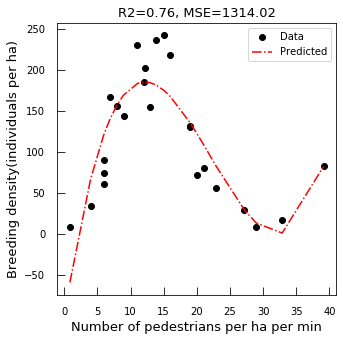

In [7]:
from utils import poly_fit

poly_fit(X.reshape(-1,1),y)

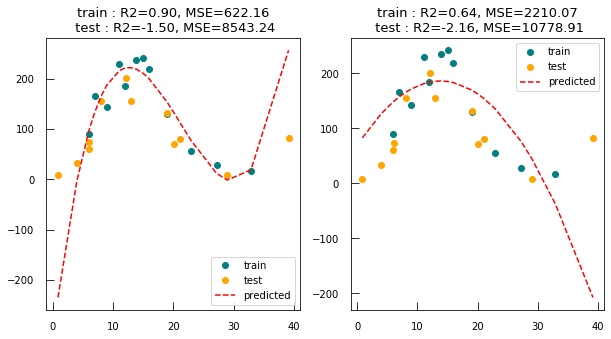

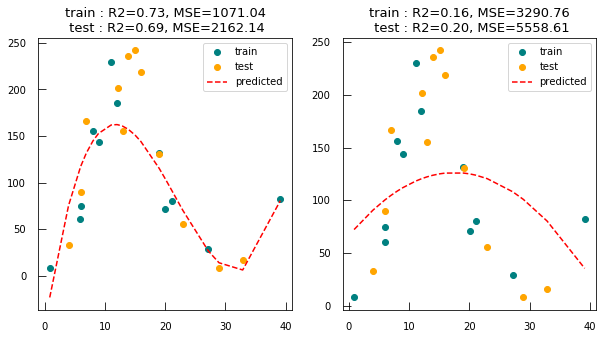

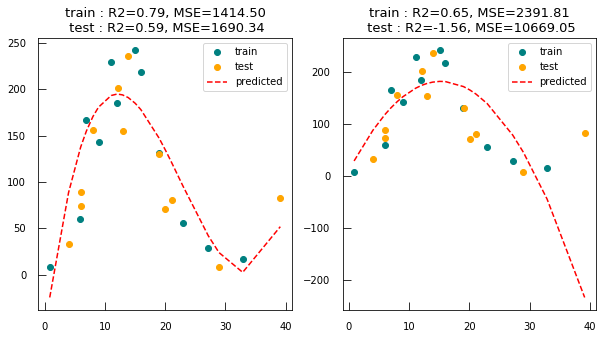

In [8]:
from utils import poly_fit_train_test

cubic=[]
quadratic=[]
for i in range(3): 
    seed = np.random.randint( 1492 )
    fig, ax = plt.subplots( 1 , 2 , figsize=(10,5) )
    
    cubic_metrics = poly_fit_train_test(X.reshape(-1,1),y, seed = seed, deg = 3 , ax = ax[0])
    quad_metrics  = poly_fit_train_test(X.reshape(-1,1),y, seed = seed, deg = 2 , ax = ax[1])
    
    cubic.append(cubic_metrics)
    quadratic.append(quad_metrics)
   

Let's see what are the R2 that we get between cubic and quadratic for many splitting of the dataset and for known and unknown data points.

Text(0.5, 0, 'R2')

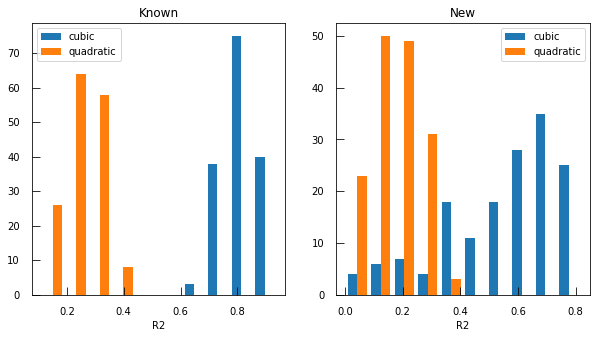

In [10]:
cubic=[]
quadratic=[]
for i in range(500): 
    seed = np.random.randint( 149217 )
    pp=poly_fit_train_test(X.reshape(-1,1),y,seed,3,ax=None)
    popo=poly_fit_train_test(X.reshape(-1,1),y,seed,2,ax=None)
    if min(pp)>0 and min(popo)>0:
        cubic.append(pp)
        quadratic.append(popo)
    
fig, ax = plt.subplots(1, 2,figsize=(10,5))
ax[0].hist([[v[0] for v in cubic],[v[0] for v in quadratic]],label=['cubic','quadratic'])
ax[0].set_title('Known')
ax[0].legend(loc='best')
ax[0].set_xlabel('R2')

ax[1].hist([[v[1] for v in cubic],[v[1] for v in quadratic]],label=['cubic','quadratic'])
ax[1].set_title('New')
ax[1].legend(loc='best')
ax[1].set_xlabel('R2')

We see here that in most of those random cases the cubic model gives better prediction on the new data points. Yet all the outcome of those fitting are a bit different. How do we reconcile them?

## Splitting data and regularization. <a class="anchor" id="split-reg"></a>

**Maybe then, what you would like to do is to find the model that is best at predicting new data point whatever the specific data you fit on is.** You don't want to underfit neither overfit and start modeling the noise of your data. You need to find a compromize. You will sometime hear people use the terms biais variance problem or the curse of dimensionality when refering to that problem.

The approach used for that is a mix of what's called regularization, and splitting of your dataset. Regularization, as its name indicates has the ambition to smoothen your fit, to make sure that you don't start to fit the noise in your data so you can be as general in your prediction as possible.  It does that by putting another layer of constraints on your covariables (features). That constraint on your covariable translates in either the objective function you want to maximize/minimize (by adding a term in your least square or your maximum likelihood), or by constraining the space of available models.

Wathever that regularization is, its strength is alway optimized by looking at subsamples of the dataset.

It is a nice automated way for model exploration, generalization and testing, which for me really defines machine learning. All of this is related to something called the curse of dimensionality. **And in any case, it relies on a splitting of your data set between at least a train and a test set**.

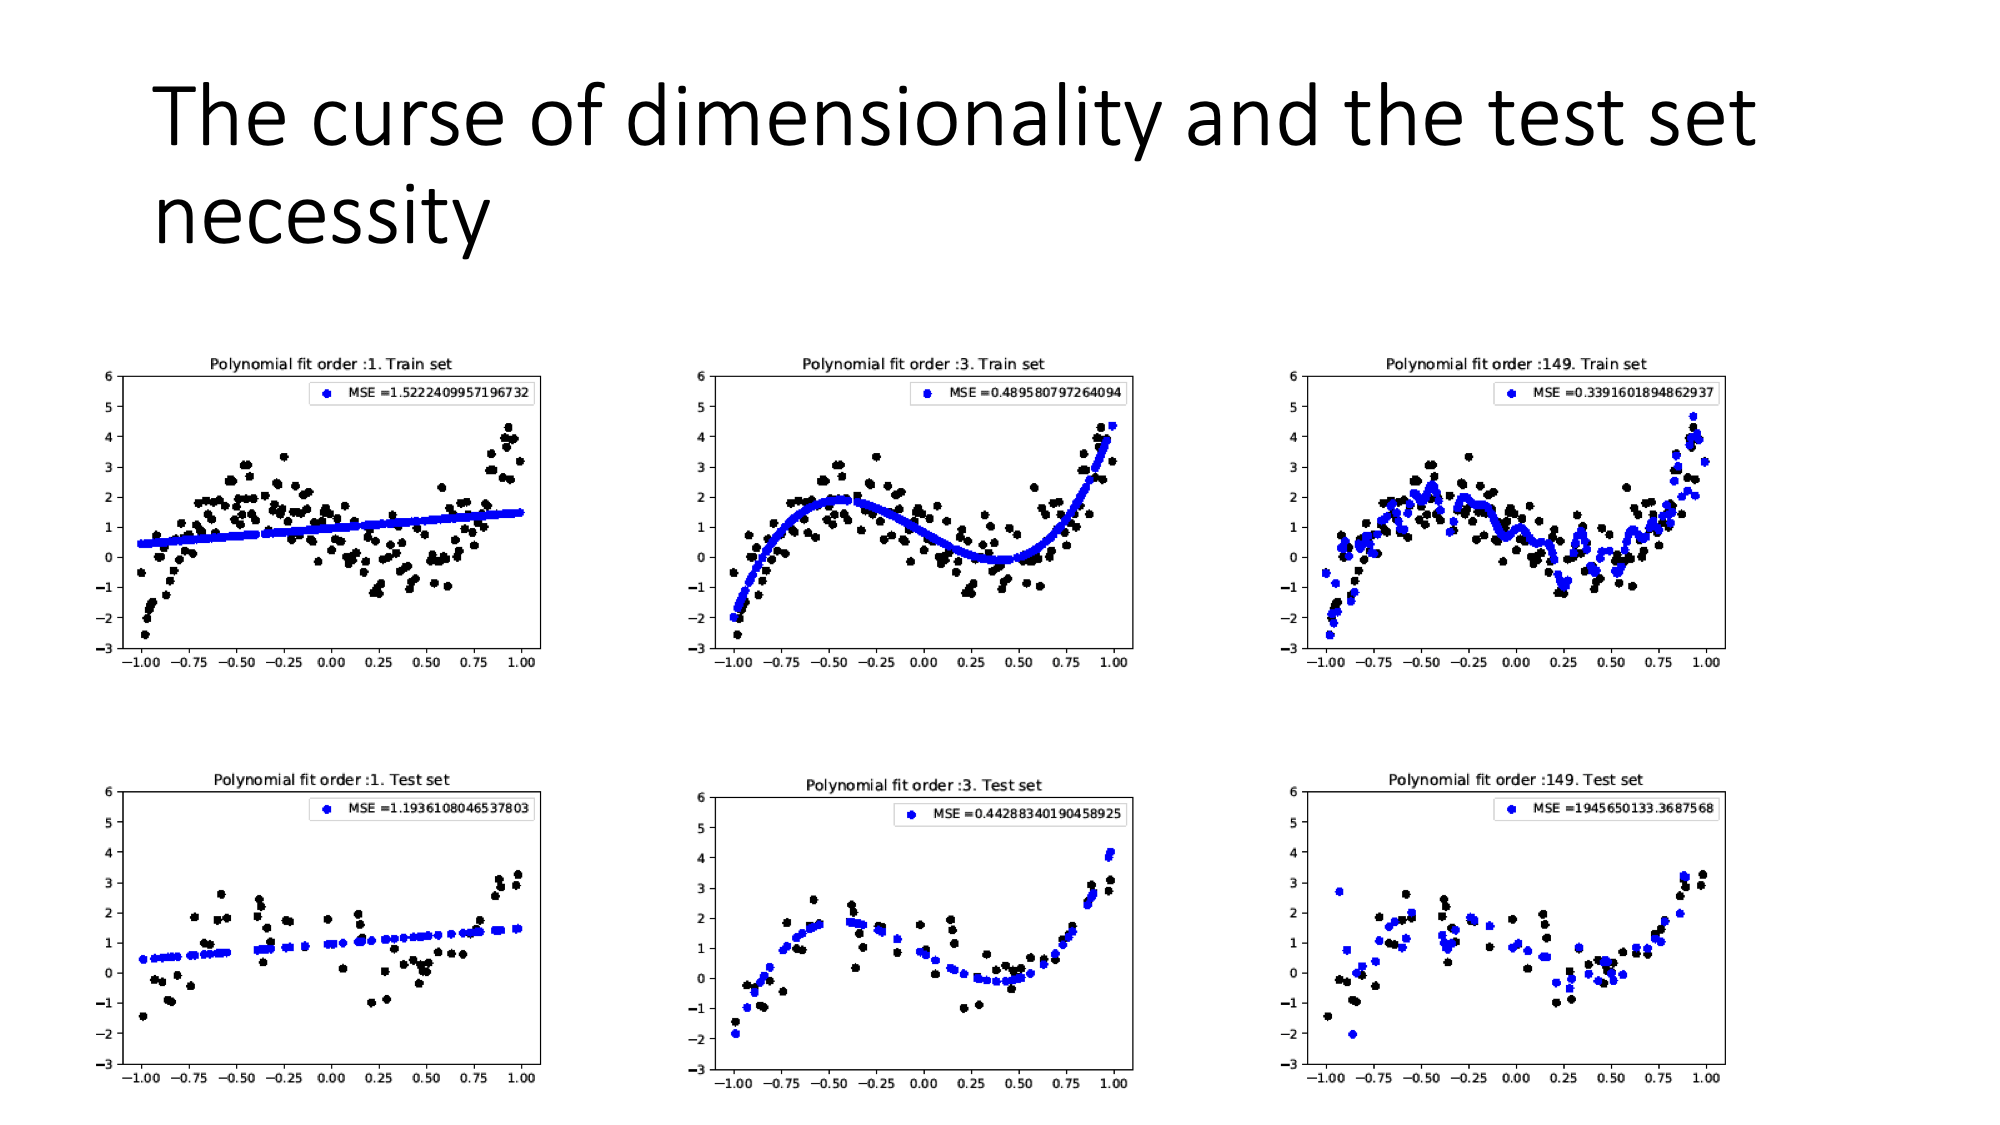

In [11]:
from IPython.display import Image

Image('Presentation1.png')

You need the test set to assess the actual generalization of your model. **This test set should not be touched until the evaluation of your model.** Ideally by then you are looking at a model which is both good on the train and the test set.

You can imagine that it is the noise that makes the coefficient in front of the 149th polynomial look very important (so big), because here by construction we know that a fit with a polynomial greater than 3 is going to fit the noise. So you should penalize big coefficients unless they are absolutely necessary. Here necessary is to be understood as necessary for understanding all the subsamples of your data.

# Regularization in the case of OLS and GLM with binomial distribution <a class="anchor" id="explore-model-general"></a>

## Definition <a class="anchor" id="regularization-definition"></a>

In case of a Least Square fitting, you just have to add to your sum of squared errors a function that takes into account the parameters in front of your covariables. Looking at those equations you penalize weights that will take too much importance in the fitting, unless they are important in every substet of data that you fit on. We will see how those subsets are designed later on. By evaluating this new loss function on many subsets of the data we can perfom model comparison and choose model generalization, all at once. 

$\sum_i (y_i-f(\pmb X_i,\pmb{\beta}))^2 + \alpha\sum_{j}|\beta_{j}|$ , **l1 regularization** (Lasso) $\alpha$ being the weight that you put on that regularization 

$\sum_i (y_i-f(\pmb X_i,\pmb{\beta}))^2 + \alpha\sum_{j}\beta_{j}^{2}$ , **l2 regularization** (Ridge) 

$\sum_i (y_i-f(\pmb X_i,\pmb{\beta}))^2 + \alpha\sum_{j}(\alpha|\beta_{j}|+(1-\alpha)\beta_{j}^{2})$ , **elasticnet**

For a deeper understanding of those notions, you may look at :

 * https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net

 * https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a


In case of a logistic regression you want to maximize your log likelihood which is now penalized by one of those functions:

$\sum_{i}log(p_{i}) - \alpha\sum_{j}|\beta_{j}|$ , **l1 regularization** (Lasso) 

$\sum_{i}log(p_{i}) - \alpha\sum_{j}\beta_{j}^{2}$ , **l2 regularization** (Ridge) 

$\sum_{i}log(p_{i}) - \alpha\sum_{j}(l_{1 ratio}|\beta_{j}|+(1-l_{1 ratio})\beta_{j}^{2})$ , **elasticnet**

Rule is : **when you hypothesize that you have sparse features and so you believe that among all those features only a small subset is going to be interesting (but of course you don't know which one...) then you try to use the regularization that will tend to put more of your features at the zero weight (the l1 regularization) and so reduce the complexity of your model.** This l1 norm that collapses non important features to zero is another way to do feature selection.


Now, we need a way to find this coefficient $\alpha$ which will set the strength of our regularization. This parameter is called an **hyperparameter**, and cannot be found directly like the others, since even if it is part of a new model it serve a generalization purpose and so should not be found by optimization on our full dataset. To do that on top of our first splitting between train dataset and test dataset, we will need to perfom some more splitting of our train data set.

> Note : the polynomial number we were using before is also an hyperparameter and can be find by the same technic consisting of splitting our data. Later on we will see other hyperparameters that are either related to model choice or regularization or intrically both.

## Oversimplified example on Kyphosis dataset <a class="anchor" id="explore-model-general"></a>

Let's check what this regularization does for our kyphosis dataset, considering only age and number as covariables, and only one split of the data into train and test.

We will, for now, focus on one particular metric to evaluate our model : **accuracy**. 

Accuracy just calculates the fraction of modeled labels that are the same than the ground truth labels.

In [12]:
df_kyphosis=pd.read_csv('kyphosis.csv')
y=[1 if v=="present" else 0 for v in df_kyphosis["Kyphosis"]]
df_kyphosis.drop("Kyphosis",1,inplace=True)
df_kyphosis.drop("Start",1,inplace=True)
df_kyphosis.head()

Age  Number
0   71       3
1  158       3
2  128       4
3    2       5
4    1       4

On the full data set

/home/wandrille/Installed_software/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


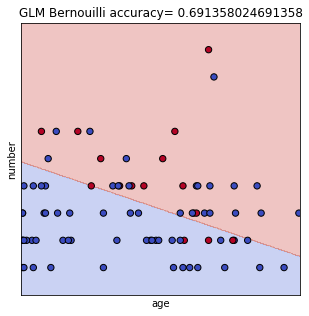

[[0.01151059205064652, 'Age'], [0.6862714429021181, 'Number'], 'intercept', array([-4.03353414])]


In [13]:
from utils import countour_lr_kypho
countour_lr_kypho(np.array(df_kyphosis),y,df_kyphosis)

inverses of alpha 10.0 , 2.154434690031884 , 0.464158883361278 , 0.1


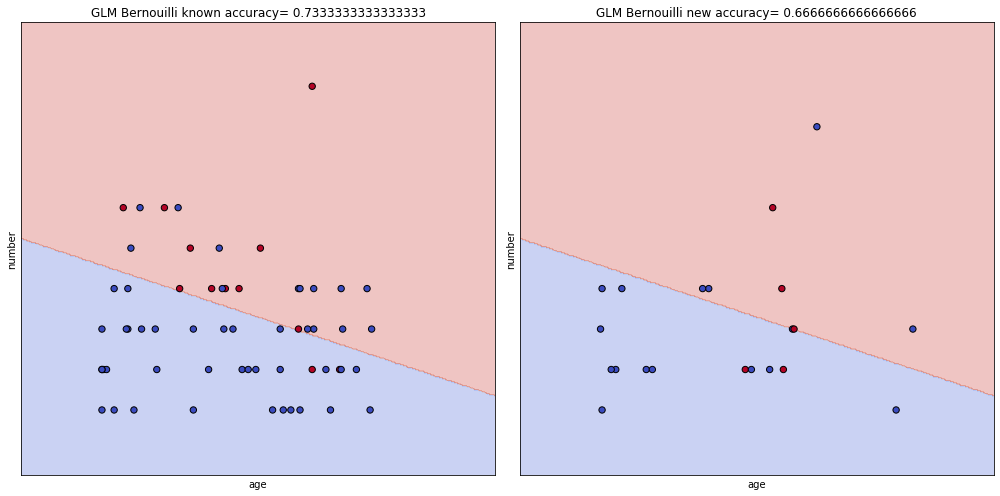

[[0.6519892495014521, 'Age'], [1.4940833222206689, 'Number'], 'intercept', array([-0.44324091])]


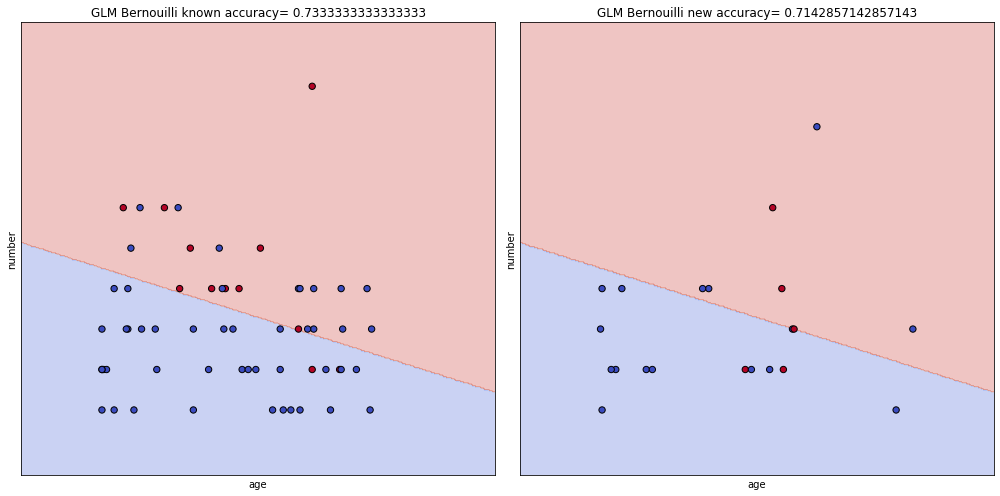

[[0.5739195131956122, 'Age'], [1.3812937153356293, 'Number'], 'intercept', array([-0.39442718])]


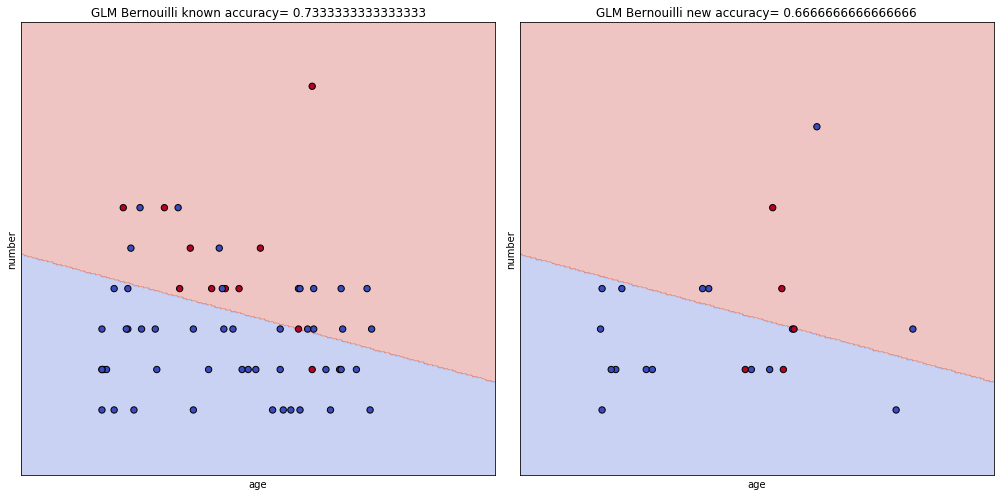

[[0.3828780433476158, 'Age'], [1.0796524140238564, 'Number'], 'intercept', array([-0.27238302])]


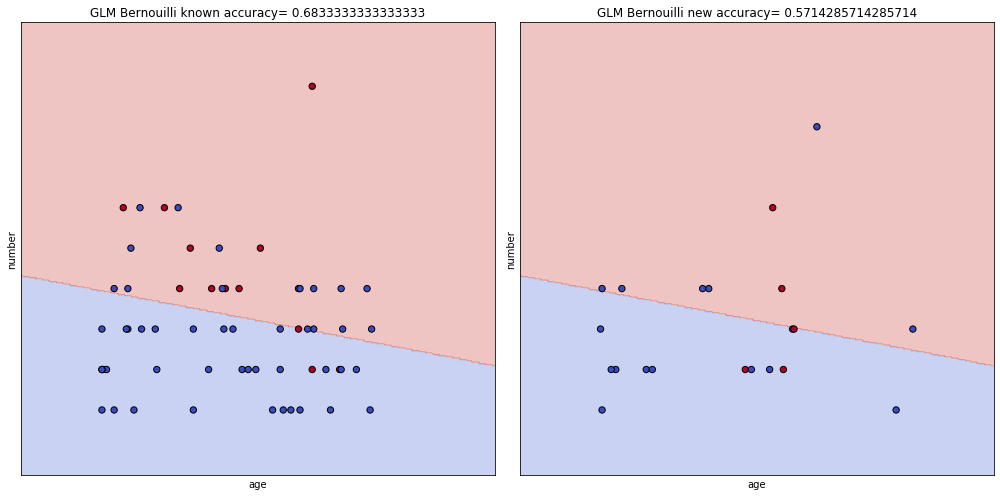

[[0.15810304159824193, 'Age'], [0.6301411596680963, 'Number'], 'intercept', array([-0.11424074])]


In [18]:
from utils import countour_lr_kypho_train_test
alpha_acc=[]
print("inverses of alpha", ' , '.join([str(x) for x in np.logspace(1,-1,4) ] ) )  
for p in np.logspace(1,-1,4):#exploring different strength of regularization (different alphas)
    tt=countour_lr_kypho_train_test(df_kyphosis,y,0,c=p,plot=True)
    alpha_acc.append(tt)
    

Text(0.5, 0, '$\\alpha$')

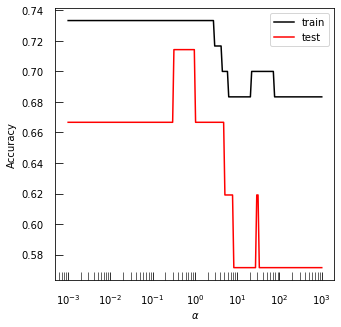

In [19]:
alpha_acc=[]
xx=np.logspace(3,-3,200)
for p in xx:#exploring different strength of regularization
    tt=countour_lr_kypho_train_test(df_kyphosis,y,0,c=p,plot=False)
    alpha_acc.append(tt)



fig, ax = plt.subplots(1, 1,figsize=(5,5))
ax.plot(1./xx,[v[0] for v in alpha_acc],'k-',label='train')
ax.plot(1./xx,[v[1] for v in alpha_acc],'r-',label='test')
#ax.plot([1,1],[0.55,0.75],'k--')
ax.set_xscale('log')
ax.legend(loc='best')
ax.set_ylabel("Accuracy")
ax.set_xlabel("$\\alpha$")

We can see that with the strength of the regularization increasing both train and test accuracy decrease (at some point at least). But we can also see that there is a couple of $\alpha$ for which the accuracy on the train set is not too much perturbed but the accuracy on the test set is greatly increased. Here some regularization seems to be advantageous to find a model that is more general. As a note, having a training score that is very high, like 0.99, should only be considered ok if the test score is high enough too. Else you are overfitting. You need to find the sweet spot which is here quite obvious.

Please note that here the regularization strength is only tested on one subsample of the data, which is the test set. This is not how you should proceed. It is just a visual example. If you pick your hyperparameter because it is the best on the test set then you biased it. You should pick it according to a validation set or a cross-validation set, and only when the model is fully trained with the hyperparameters that you chose, assess the generalizability of the model by using the test set.

Indeed if we would proceed like that we would be finding the best $\alpha$ for a particular test set. This is biasing our understanding of the generalization of our model.

# The machine learning framework <a class="anchor" id="ML-framework"></a>

**There is actually two ways to handle this task. Either you have enough data and you split your train set, once and for all, into a train and a validation set. Or you do what's called a cross validation. Cross validation is going to split your train set into k subparts and you are going to train your model on k-1 subparts pooled together and validate it on the remaining subpart. You do that for all the possible pairs of k-1 subparts. You keep the strenght of your regularization which is in average the best . Either way you keep your test set untouched until the end whatever happens.**

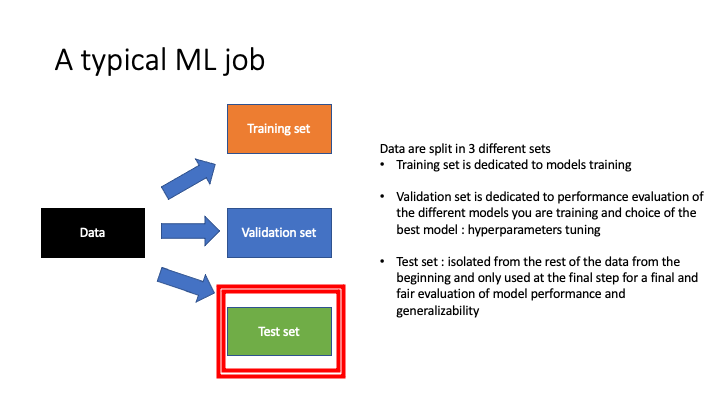

In [25]:
Image('Presentation3.png')

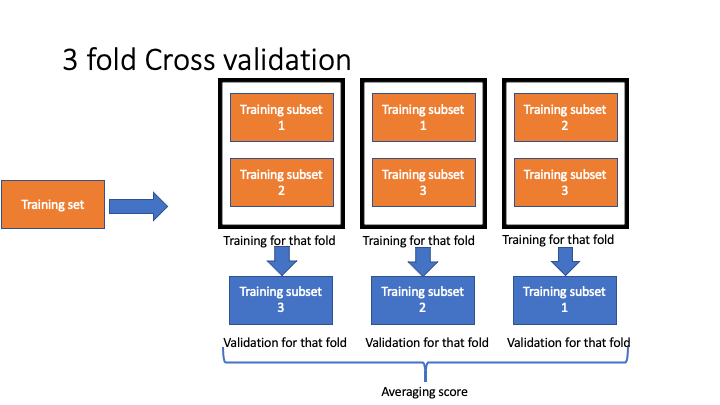

In [26]:
Image('Presentation4.png')

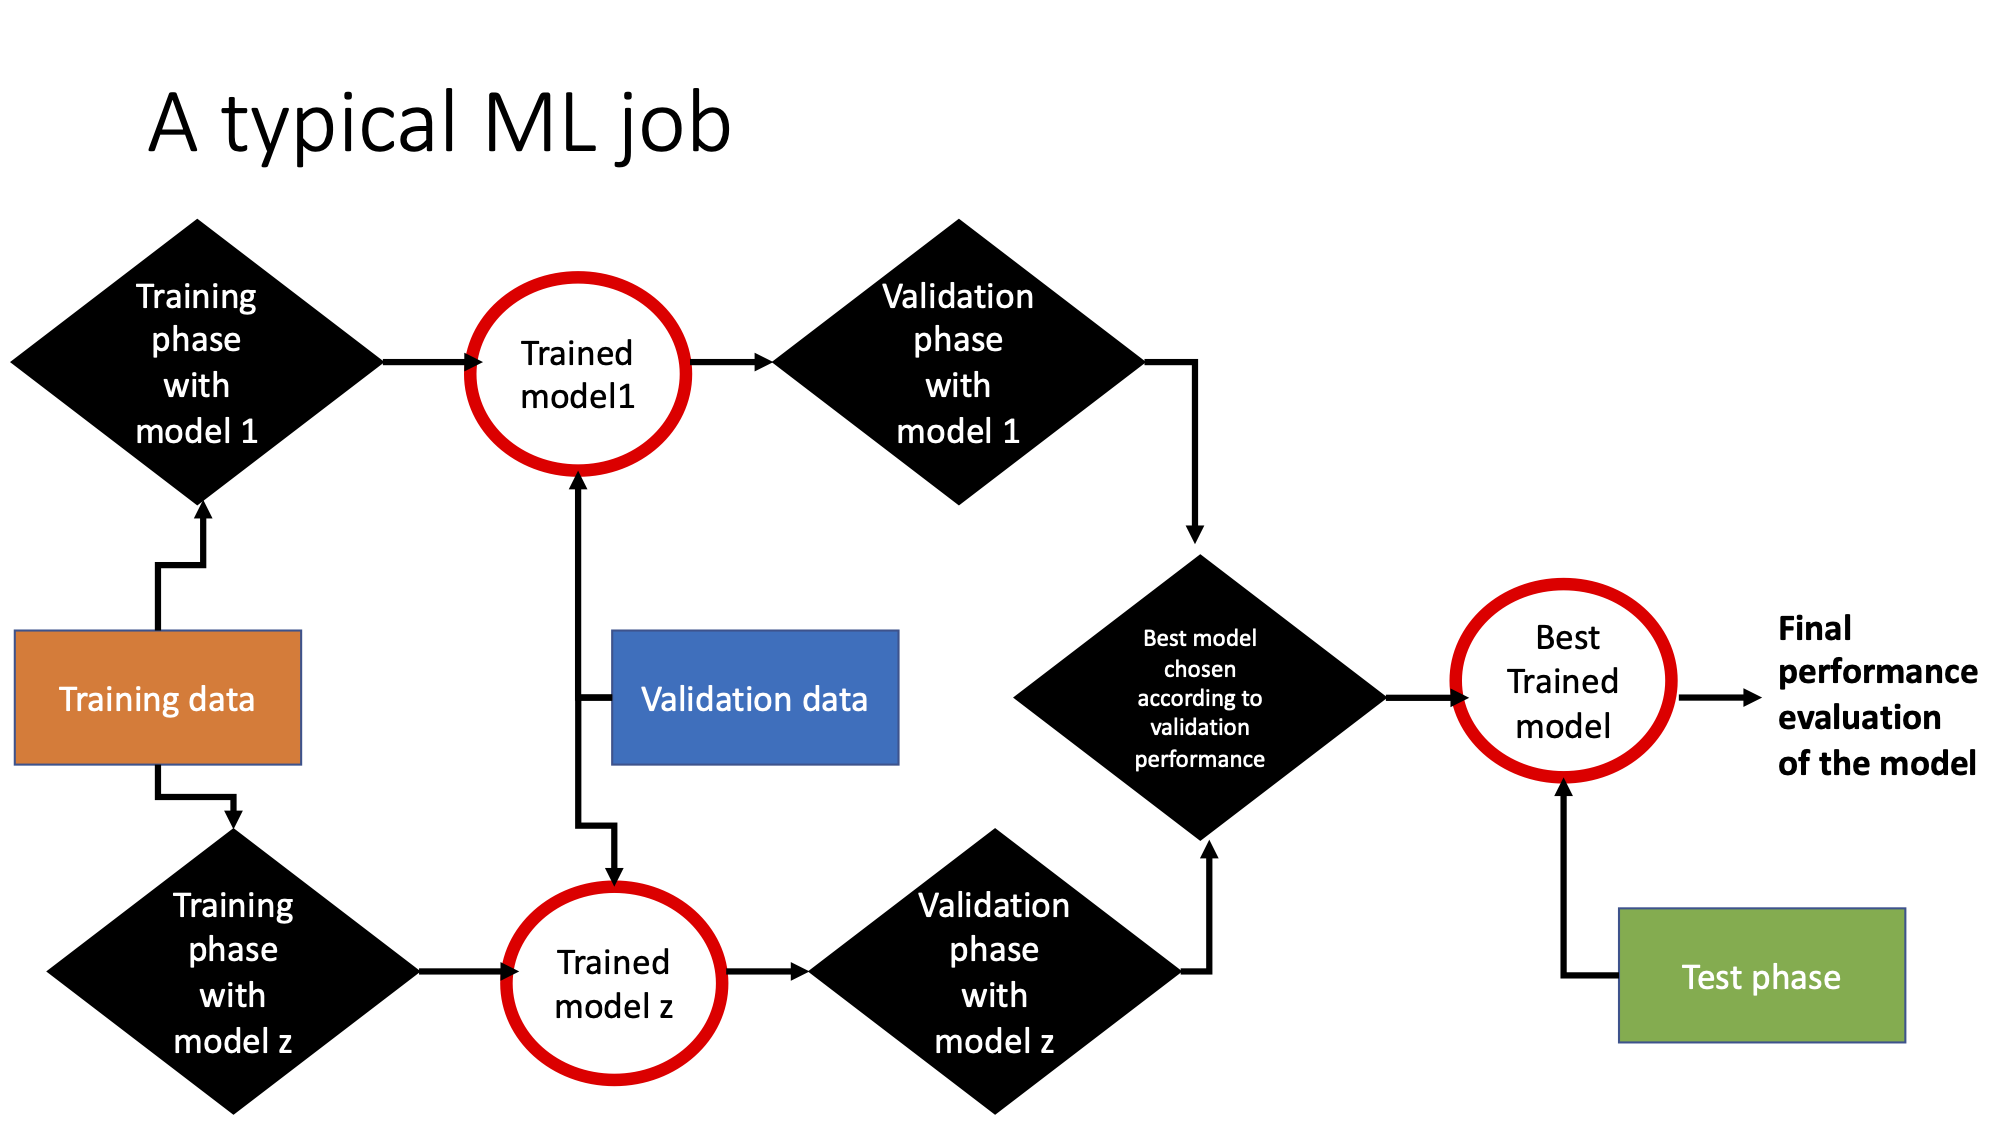

In [27]:
Image('Presentation2.png')

For those kind of method to work, since we are solicitting our dataset many times, you need to have quite a lot of points. Typically the number of points for our sparrow disturbance is too small to perform nicely this procedure. Same for the kyphosis dataset. Particularly, in this last case, the problem comes from the fact that the dataset is unbalanced (only 17 present kyphosis).
# Logistic regression and OLS regression. <a class="anchor" id="lr-ols"></a>
## A toy model to visualize logistic regression. <a class="anchor" id="toy-example-lr"></a>

So for the next examples, let's work on clear simulated data to explore more easily how to proceed to that Machime Learning job.

Imagine we want to create a model able to separate those two classes

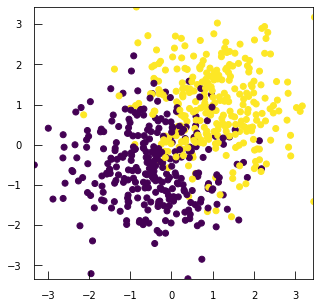

In [34]:
from sklearn.datasets import make_blobs

#making toy data

X2, y2 = make_blobs(n_samples=600, centers=[[-0.5,-0.5],[1,1]],cluster_std=[[1,1],[1,1]], random_state=6)


plt.scatter(X2[:,0],X2[:,1],c=y2)
plt.xlim(min(X2[:,1]),max(X2[:,1]))
plt.ylim(min(X2[:,1]),max(X2[:,1]))
plt.show()

We try it with logistic regression and regularization l2 for different strength of regularization $\alpha$ 

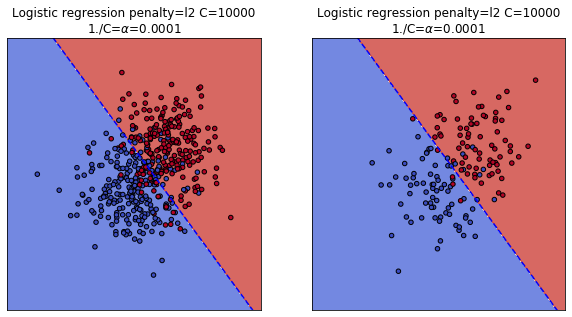

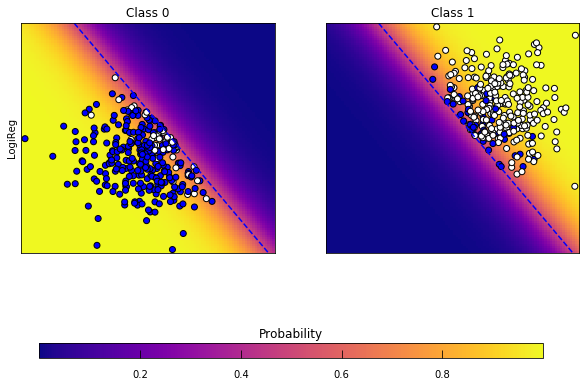

C:\Users\rache\Documents\Advanced_statistics\utils.py:457: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


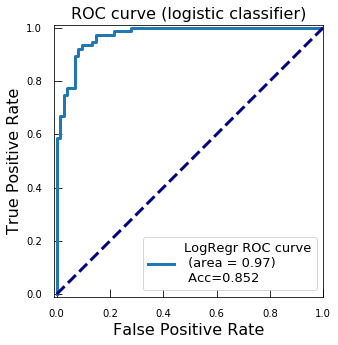

In [35]:
from utils import countour_lr
countour_lr('l2',X2,y2,10000,'ovr')

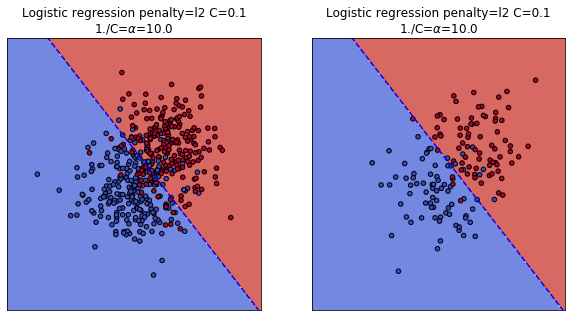

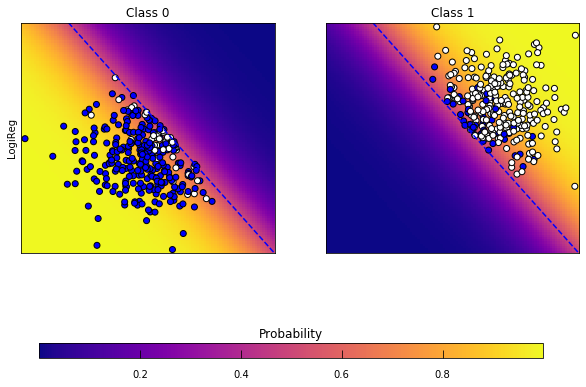

C:\Users\rache\Documents\Advanced_statistics\utils.py:457: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


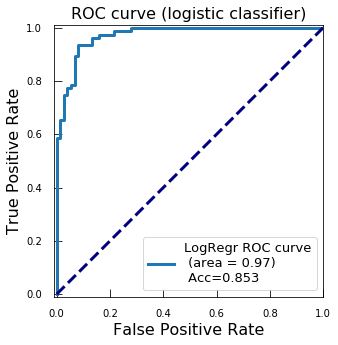

In [36]:
countour_lr('l2',X2,y2,0.1,'ovr')

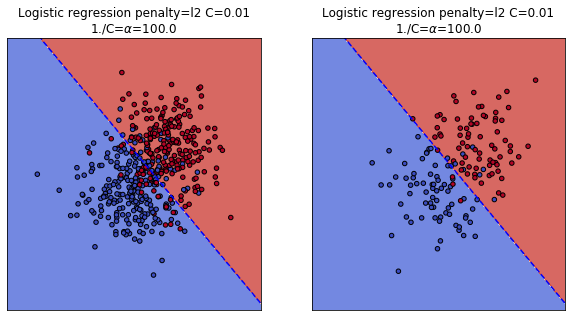

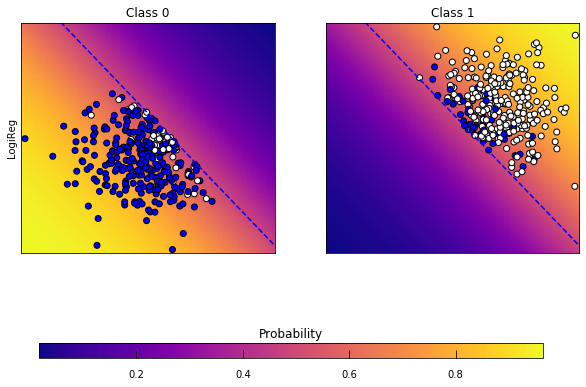

C:\Users\rache\Documents\Advanced_statistics\utils.py:457: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


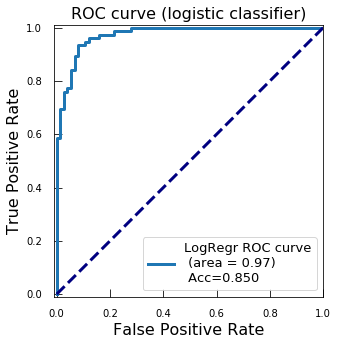

In [37]:
countour_lr('l2',X2,y2,0.01,'ovr')

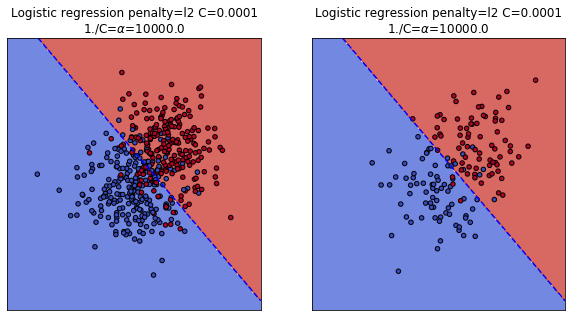

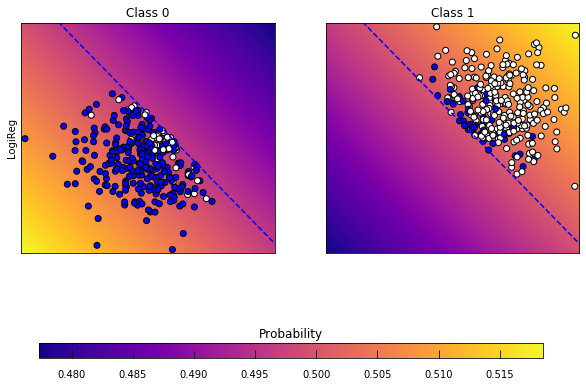

C:\Users\rache\Documents\Advanced_statistics\utils.py:457: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


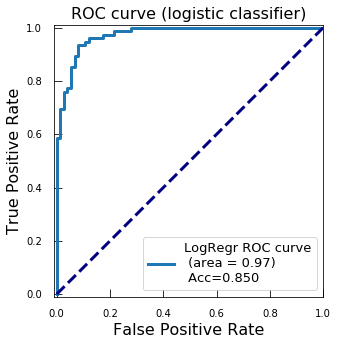

In [38]:
countour_lr('l2',X2,y2,0.0001,'ovr')

Setting the strength of regularization higher makes the boundary fusier

## A new metric to evaluate your model : AUC_ROC <a class="anchor" id="auc_roc"></a>


From how we introduced logistic regression before you can already see that all points of an hyperplane share the same probability. What is represented in the first panel is one particular hyperplane (here a line in dimension 2) **for which the probability to be part of one of the two groups is =0.5**. But actually that **is quite an arbitrary threshold**. The second panel of plots shows you **many of those different hyperplanes having different probabilities and you could in principle choose any of those lines for class delimitation.**

**But why would you do that? Well for example if you want to tune how stringent you want to be towards different error types.** If you deal with deciding if the patient you have in front of you should go for more exams because of a suspicion of malignant tumor, you don't want to miss any of those malignant tumors. It doesn't really matter if in the process you send many clean patient for further exams. So maybe in that case having a 0.5 threshold for malignant tumor calling is too stringent.

**A way to visualize those type of problem is to look at the receiver operating curve (ROC). In this curve each point is a particular threshold and its coordinate are how much False positive and True positive this threshold will create.**

$FPR= \frac{FP}{FP+TN}$

$TPR= \frac{TP}{TP+FN}$

FPR : False Positive Rate, TPR : True Positive Rate, TP: True Positive, TN: True Negative, FP: False Positive, FN: False Negative.
**Ideally you want a curve that perfectly follows the edge of the square** : whatever threshold you use you recover all the positive and the negative samples. So the best model should have an area under the curve of 1.  In reality the curve that you will get ressemble more to the one from the third panel.

There is one more thing that I would like to add here, which makes this story about ROC curves and caring about the right metric even more important. **The diagonal line in the ROC curve represents what is called a dummy classifier. It is a classifier that has learned only the probabilities to have one class instead of the other. The farther you are from that line the better you are (so the more area under the curve)**. Those comparisons to dummy classifier are really important when your dataset is imbalanced. Imagine the extreme case of a dataset made of 99 class 0 and 1 class 1. In that case your basal accuracy is going to be 98% : but that doesn't make your model good. It just means that it has chosen randomly 99 point to class as 0 and 1 to class as 1. **It is a bad model eventhough it has a high accuracy. The ROC AUC is sensitive to that**. So if you have imbalanced dataset use scoring that are sensitive to it. There are other ways to deal with it like weighting labels differently in the loss function. We will spend a little bit more time on the subject next. Just know that this problem exists and understand what it does through later on examples. Always check if your dataset is imbalanced or not and use some classifier that have built in functions to face that: logistic regression and SVC for example offer the use of the class_weight argument.

On the ROC curve can you find in which direction the thresholds are getting bigger?

## Imbalanced dataset <a class="anchor" id="imbalanced"></a> 

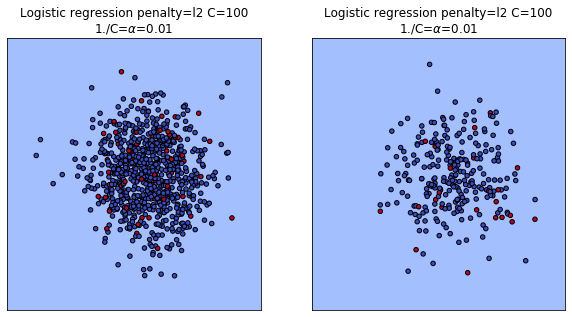

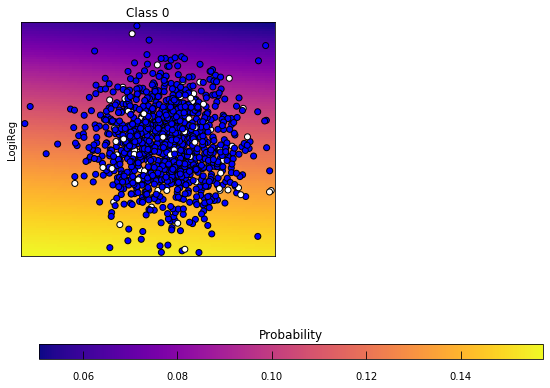

C:\Users\rache\Documents\Advanced_statistics\utils.py:457: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


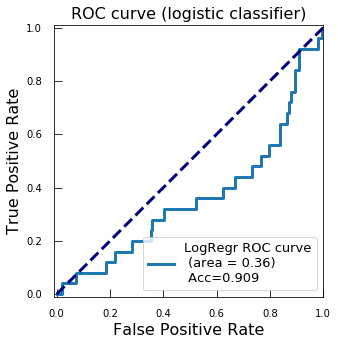

In [40]:
#making toy imbalanced dataset
X2_i, y2_i = make_blobs(n_samples=(1000,100), centers=[[1,1],[1,1]], random_state=6)
countour_lr('l2',X2_i,y2_i,100,'ovr')

**As you can see here the data was not separable from the beginning**. But just because the dataset was imbalanced (1000 of one class and only 100 of the other) and we trained our model on accuracy score **we still get a good accuracy**. But this is missleading, our model is not usefull right now, it is randomly assigning labels according to the statistics of the labels. Again, accuracy is informative but doesn't hold all the information.


If you don't feel like going through different scoring (i.e. accuracy,auc, f1 and so on), you can compare your model to a dummy classifier that will either only learn the statistic of your training set or always answer the most probable class (other dummy classifier are available): sklearn.dummy.DummyClassifier.

You might have been able to deal with this problem by reweigthing the importance of the class in the model. Logistic regression provided by scikitlearn allows that. 

## Your first classical machine learning pipeline <a class="anchor" id="lr-ols-pipeline"></a>

### On a classification problem using logistic regression. <a class="anchor" id="lr-pipeline"></a>

Let's build a logistic regression model that will be able to predict if a breast tumor is malignant or not

In [41]:
from sklearn.datasets import load_breast_cancer

#loading the dataset which is comprised in scikit learn already
data = load_breast_cancer()


X2=data['data']
y2=data['target']

#making it into a dataframe
print("Features/covariables",data["feature_names"])
breast_cancer_df=pd.DataFrame([[X2[v][u] for u in range(len(X2[v]))]for v in range(len(X2))],columns=data["feature_names"])

breast_cancer_df["target"]=data['target']



Features/covariables ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


I just want to point out here that all those covariables / features are defined on very different scale, for them to be treated faily in their comparison you need to take that into account.

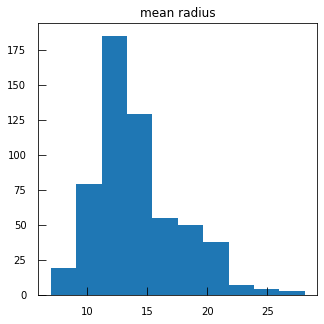

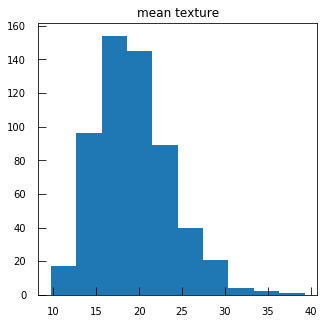

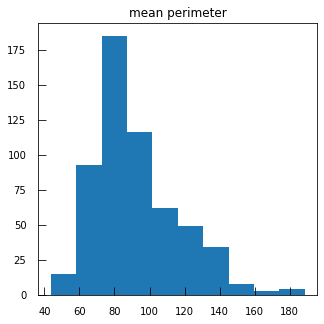

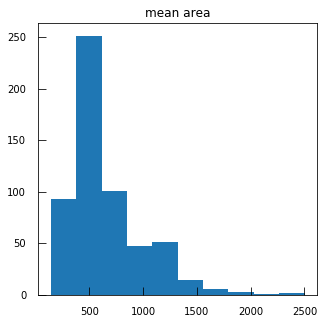

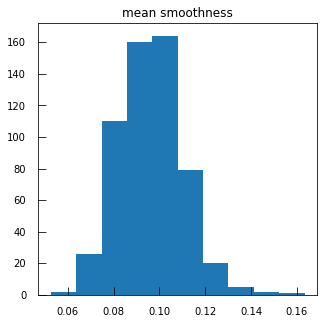

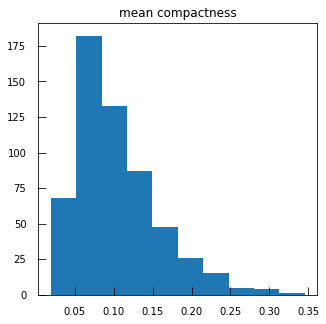

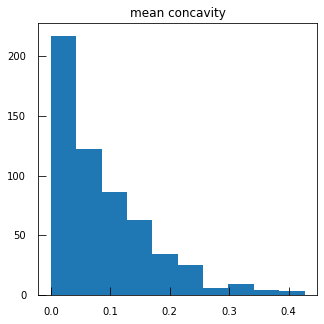

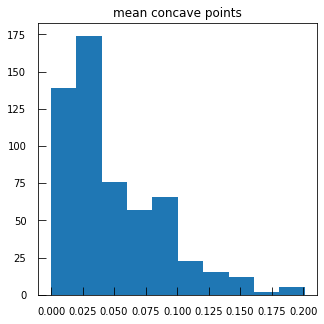

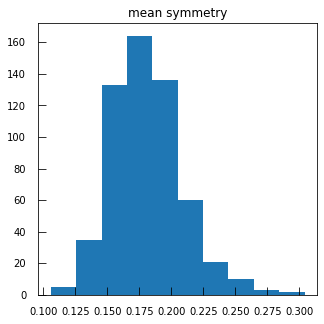

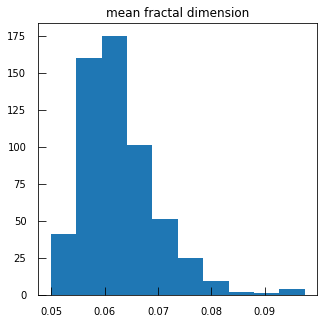

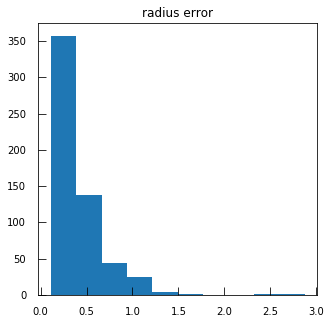

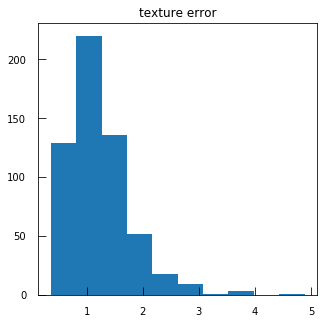

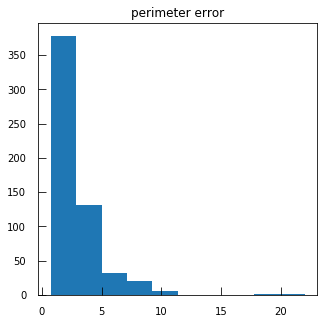

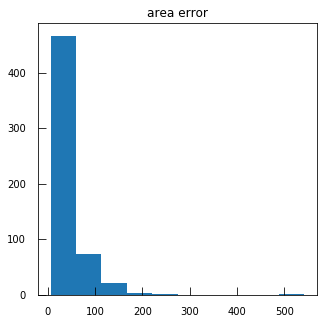

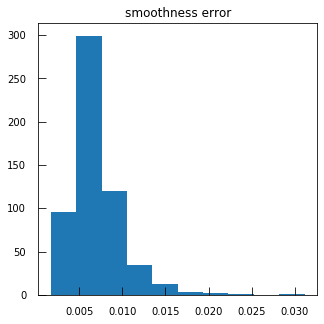

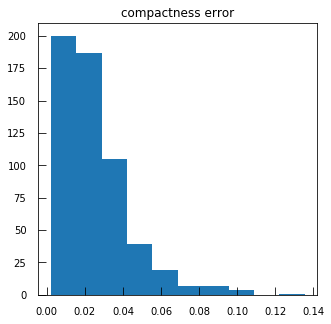

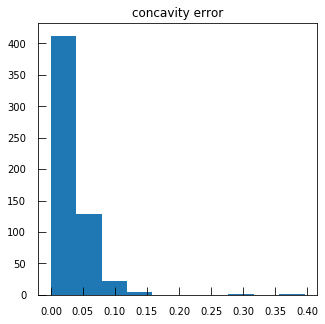

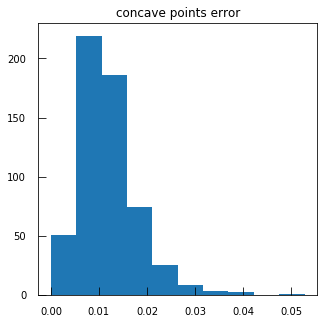

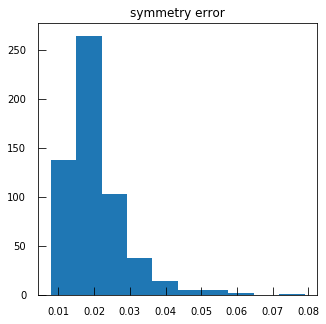

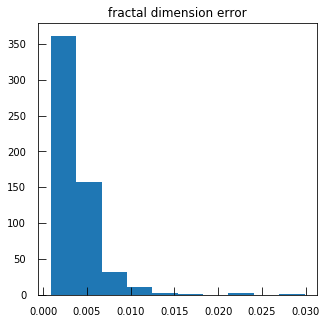

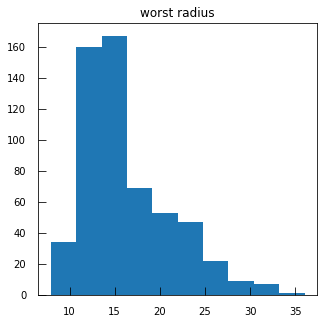

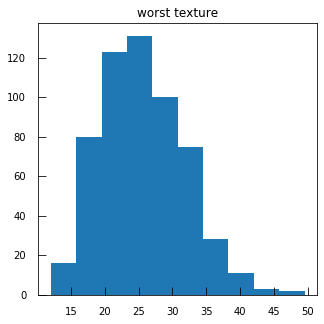

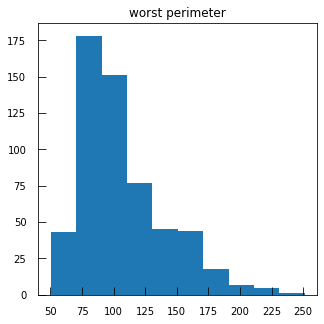

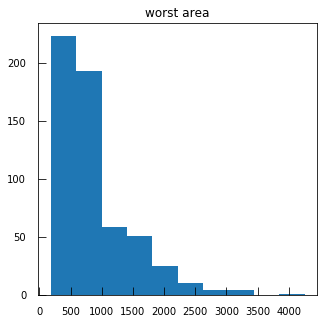

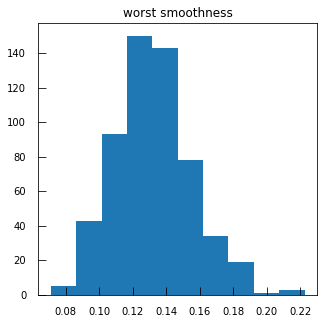

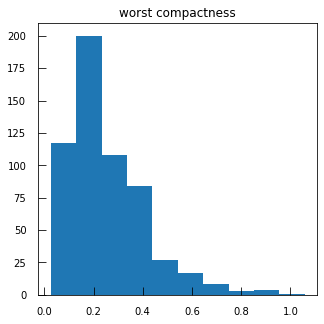

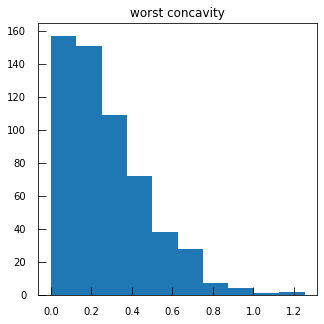

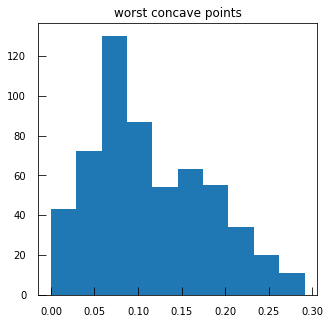

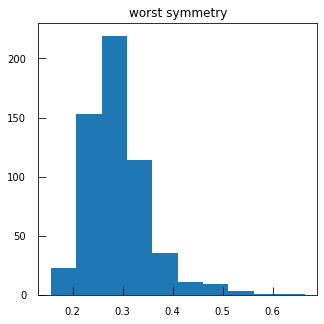

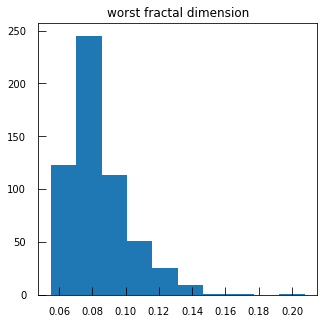

In [42]:
#let's just check how those features are distributed
std_feature={}
for i in range(X2.shape[1]):
    plt.hist(X2[:,i])
    std_feature[data["feature_names"][i]]=np.std(X2[:,i])
    plt.title(data["feature_names"][i])
    plt.show()

fraction of class benign in train 0.6267605633802817 fraction of class benign in test 0.6293706293706294 fraction of class benign in full 0.6274165202108963
Grid best parameter (max.accuracy):  {'model__C': 0.06579332246575675, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Grid best score (accuracy):  0.9835841313269494
Grid best parameter (max.accuracy) model on test:  0.9440559440559441
confusion matrix
[[50  3]
 [ 5 85]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.93        53
           1       0.97      0.94      0.96        90

    accuracy                           0.94       143
   macro avg       0.94      0.94      0.94       143
weighted avg       0.94      0.94      0.94       143



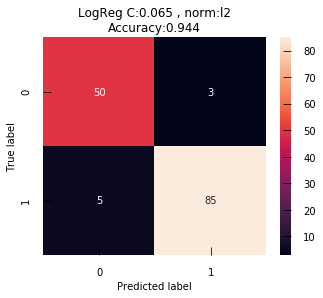

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


#split your data

X_train, X_test, y_train, y_test = train_test_split(X2,y2,
                                                   random_state=0,stratify=y2)
#stratify is here to make sure that you split keeping the repartition of labels unaffected

print("fraction of class benign in train",sum(y_train)/len(y_train),"fraction of class benign in test",sum(y_test)/len(y_test),"fraction of class benign in full",sum(y2)/len(y2))

#define the score that you want to optimize
sco='accuracy'

from sklearn.pipeline import Pipeline

#create your logistic regression object, the class being slightly unbalanced add a class weight
logi_r=LogisticRegression(class_weight='balanced')



#put it in a pipeline : the pipeline allows you to put tasks to perfom in a sequential manner.
#Here particularly to scale subset of your data at a time when you will use the cross
#validation technique. By doing the scaling on each subset that is going for validation instead of 
#on the full training set
#you make sure that information about your test and validation are not leaking in your training.
#Scaling is important for some optimizers, generally speaking for technics other than logistic
#regression or decision tree, when you add a Lasso or Ridge regularization,
#when dealing with covariables that have a variety of scales, and finally I believe make model intepretation easier.

pipeline_lr=Pipeline([('scalar',StandardScaler()),('model',logi_r)])

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

grid_values = {'model__C': np.logspace(-5,2,100),'model__penalty':['l1','l2'],'model__solver':['liblinear']}
# define the hyperparameters you want to test
#with the range over which you want it to be tested. Note the model double underscore name of the parameters.

grid_lr_acc = GridSearchCV(pipeline_lr, param_grid = grid_values, scoring=sco)#Feed it to the GridSearchCV with the right
#score(here sco) over which the decision should be taken

grid_lr_acc.fit(X_train, y_train)#train your pipeline

y_decision_fn_scores_acc=grid_lr_acc.score(X_test,y_test)# calculate the score of your trained pipeline on the test

print('Grid best parameter (max.'+sco+'): ', grid_lr_acc.best_params_)#get the best parameters
print('Grid best score ('+sco+'): ', grid_lr_acc.best_score_)#get the best score calculated from the train/validation
#dataset
print('Grid best parameter (max.'+sco+') model on test: ', y_decision_fn_scores_acc)# get the equivalent score on the test
#dataset : again this is the important metric



from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

y_pred_test_c=grid_lr_acc.predict(X_test)#predict y_test from X_test thanks to your trained model

confusion_mc_c = confusion_matrix(y_test, y_pred_test_c)# check the number of mistake made with the default 
#threshold for your decision function
print("confusion matrix")
print(confusion_mc_c)
df_cm_c = pd.DataFrame(confusion_mc_c, 
                     index = [i for i in range(2)], columns = [i for i in range(2)])

plt.figure(figsize=(5,4))
sns.heatmap(df_cm_c, annot=True)
plt.title('LogReg C:'+str(grid_lr_acc.best_params_['model__C'])[:5]
          +' , norm:'+grid_lr_acc.best_params_['model__penalty']+'\nAccuracy:{0:.3f}'.format(accuracy_score(y_test, 
                                                                       y_pred_test_c)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

print(classification_report(y_test, y_pred_test_c))# check the overall capacity of your model on test set 
#according to a bunch of metric

Area under your ROC curve 0.9924528301886792


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


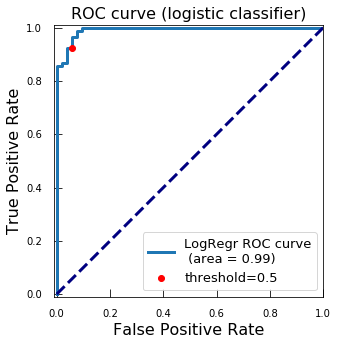

In [50]:
import scipy as sc
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
# this three lines here are how you get the area under the ROC curve score which is very important for evaluating your model
y_score_lr_c = grid_lr_acc.decision_function(X_test)#decision_function gives you the proba for a point to be in
# a class
fpr_lr_c, tpr_lr_c, thre = roc_curve(y_test, y_score_lr_c)# this calculates the ROC curve
roc_auc_lr_c = auc(fpr_lr_c, tpr_lr_c)#finally this calculates the area under the curve
print("Area under your ROC curve",roc_auc_lr_c)

#this part is just to check where your probability threshold of 0.5 sit on the roc curve
proba=sc.special.expit(thre)
for i in range(len(proba)):
    if abs(proba[i]-0.5)<0.1:
        keep=i
        break
        

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr_c, tpr_lr_c, lw=3, label='LogRegr ROC curve\n (area = {:0.2f})'.format(roc_auc_lr_c))
plt.plot(fpr_lr_c[keep], tpr_lr_c[keep],'ro',label='threshold=0.5')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (logistic classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

In [51]:
from operator import itemgetter
from sklearn.preprocessing import StandardScaler

#The problem with GridSearchCV is that it doesn't give you access to the actual weights in front of your features.
#We have to manually retrain our model with best hyperparameters found in GridSearchCV

scaler = StandardScaler()# Create a scaler instance 
scaler.fit(X_train)# Fit only on train
X_train_scaled=scaler.transform(X_train)# actual transform your data into scaled data
X_test_scaled=scaler.transform(X_test)

lr = LogisticRegression(penalty=grid_lr_acc.best_params_['model__penalty'],C=grid_lr_acc.best_params_['model__C'],
                       solver=grid_lr_acc.best_params_['model__solver'])
lr.fit(X_train_scaled, y_train)
w=lr.coef_[0]#get the weights

sorted_features=sorted([[data["feature_names"][i],abs(w[i])] for i in range(len(w))],key=itemgetter(1),reverse=True)

print('Features sorted per importance in discriminative process')
print(sorted_features)

Features sorted per importance in discriminative process
[['worst radius', 0.4675249559927838], ['worst texture', 0.46547266657431813], ['worst concave points', 0.44619282549484574], ['worst perimeter', 0.435265527295262], ['worst area', 0.43382192009233767], ['mean concave points', 0.42242624538769324], ['mean radius', 0.3646585123343495], ['mean area', 0.36445589930722766], ['mean perimeter', 0.35561165292396996], ['radius error', 0.3526296869822475], ['mean concavity', 0.34772534513033365], ['worst concavity', 0.309036469604688], ['worst smoothness', 0.3065462585713618], ['mean texture', 0.2988561127907173], ['area error', 0.2939011252193204], ['worst symmetry', 0.28522302995744225], ['perimeter error', 0.2637438774546016], ['mean fractal dimension', 0.18491537576978986], ['worst compactness', 0.16235193923712943], ['worst fractal dimension', 0.1517592547872387], ['compactness error', 0.14031203938596654], ['fractal dimension error', 0.13072961682069265], ['symmetry error', 0.108752

In [52]:
# Those are the other scores (other than accuracy and roc_auc) to evaluate the performence of your model.
#If you recall we used scoring=accuracy in our GridSearchCV. But we could use another metric.

from sklearn.metrics.scorer import SCORERS

print(sorted(list(SCORERS.keys())))

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'v_measure_score']


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### On a regression problem using OLS regression and regularization . <a class="anchor" id="ols-pipeline"></a>

Let's check a regression problem this time instead of a classification. For that we are going to build a model that is, to some extent, able to predict evolution of diabetes from some features.

In [53]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()

df_diabetes=pd.DataFrame([[diabetes['data'][j,i] for i in range(len(diabetes['feature_names'])) if diabetes['feature_names'][i]!="sex"] for j in range(diabetes['data'].shape[0])],
                         columns=[diabetes['feature_names'][i] for i in range(len(diabetes['feature_names']))if diabetes['feature_names'][i]!="sex"])


In [54]:
print(diabetes['feature_names'],'age,sex,body mass index,average blood pressure,total cholesterol,Low-density lipoprotein,High-density lipoprotein,tch,ltg,glu')




['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'] age,sex,body mass index,average blood pressure,total cholesterol,Low-density lipoprotein,High-density lipoprotein,tch,ltg,glu


In [55]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from operator import itemgetter
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split


X_diabetes_train, X_diabetes_test, y_diabetes_train, y_diabetes_test = train_test_split(np.array(df_diabetes), np.array(diabetes['target']),
                                                   random_state=0)#always split your dataset and do the fitting on the training
#You will then check the goodness of fit on the test

lr_reg=SGDRegressor()# This is a special function for OLS with regularization: it uses Stochastic gradient Descent for its optimization algo. You can
#change the loss function and the learning rate. But we will not mess with that here. The learning rate adjustement is made
#cleverly by default(many ways to be clever see API description) and we will stick to the MSE loss.

sco="r2"

#in our model we will also consider polynomials for our features, thanks to that PolynomialFeature function
#more details in the in depth notebook
pipeline_lr_reg=Pipeline([('poly',PolynomialFeatures()),('scalar',StandardScaler()),
                     ('model',lr_reg)])#poly first then scalar!!!

from sklearn.model_selection import GridSearchCV


grid_values = {'poly__degree': np.arange(1,4,1),'model__penalty':['l1','l2'],'model__alpha':np.logspace(0,3,10)}# define the hyperparameters you want to test
#with the range over which you want it to be tested.Here the hyperparamters are the degree of the polynomial you want to try
# and the form of regularization you want to try (l1 or l2).Here alpha is the weight for the regularization

grid_lr_reg_acc = GridSearchCV(pipeline_lr_reg, param_grid = grid_values, scoring=sco)#Feed it to the GridSearchCV with the right
#score over which the decision should be taken (ir R^2). This part choose for you what is the best polynomial degree you should 
#use as well as the best regularization and strength of regularization

grid_lr_reg_acc.fit(X_diabetes_train, np.array(y_diabetes_train).ravel())##Where the actual fit happens

y_decision_fn_scores_acc=grid_lr_reg_acc.score(X_diabetes_test,np.array(y_diabetes_test).ravel())

print('Grid best parameter (max.'+sco+'): ', grid_lr_reg_acc.best_params_)#get the best parameters
print('Grid best score ('+sco+'): ', grid_lr_reg_acc.best_score_)#get the best score calculated from the train/validation
#dataset
print('Grid best parameter (max. '+sco+') model on test: ', y_decision_fn_scores_acc)# get the equivalent score on the test
#dataset : again this is the important metric


poly=PolynomialFeatures(degree=grid_lr_reg_acc.best_params_['poly__degree'])
X_train_poly=poly.fit_transform(X_diabetes_train)

scaler = StandardScaler() 
scaler.fit(X_train_poly)
X_train_poly_scaled=scaler.transform(X_train_poly)

lr_reg=SGDRegressor(penalty=grid_lr_reg_acc.best_params_['model__penalty'],alpha=grid_lr_reg_acc.best_params_['model__alpha'])
lr_reg.fit(X_train_poly_scaled,np.array(y_diabetes_train).ravel())
poly.powers_

sorted_list=sorted([['_'.join([df_diabetes.columns[j]+'^'+str(poly.powers_[i][j])for j in range(len(df_diabetes.columns)) if poly.powers_[i][j]>0]),abs(lr_reg.coef_[i])] for i in range(len(poly.powers_))],key=itemgetter(1),reverse=True)

print('Important features\n',sorted_list)

Grid best parameter (max.r2):  {'model__alpha': 2.154434690031884, 'model__penalty': 'l1', 'poly__degree': 1}
Grid best score (r2):  0.5136698049546474
Grid best parameter (max. r2) model on test:  0.3320145436498686
Important features
 [['bmi^1', 29.51622014552127], ['s5^1', 24.12833603311268], ['bp^1', 9.653063009465281], ['s3^1', 8.687504667381495], ['s2^1', 4.459740924895834], ['', 0.0], ['age^1', 0.0], ['s1^1', 0.0], ['s4^1', 0.0], ['s6^1', 0.0]]


## What if you want to use GLM with regularization and cross fold validation, other than binomial? <a class="anchor" id="glm"></a>

Scikit learn have implemented GLM regression. The way it is implemented is using a minimization of the deviance modified with a L2 regularization:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.TweedieRegressor.html#sklearn.linear_model.TweedieRegressor

https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-regression


# A few words on scaling <a class="anchor" id="scaling"></a>

Scaling is a really important part of the analysis. Some regressors or classifiers techniques are distance based (for example OLS, or whenever you directly use distances or when you are dealing with a covariance matrix transformation). Also when you use one of the regularization seen before (l1, l2 or elastic net), you should use scaling as the weights could bear uninformative scaling. If youd don't put all the features (covariables) on the same scale some will be artificially priviledge because of the typical distance they represent rather than what they really mean compared to other features. 

Scaling also facilitates the convergence of some optimizers. Finally I personally like it because it makes my interperetation straight forward.

There exist many different ways to scale features. Some were done for you in the last notebook, under the hood of some of the API function we were using. For example OLS and GLM were doing a L2 normalization on your covariables. In the examples above we used a standard scaler. Let's briefly list those.

sklearn.preprocessing.Normalizer: you can choose your norm eitheir l1, l2 or max :

L1 normalization for covariables $X_{:,j}$$$ \frac{X_{:,j}}{\sum_{i}|X_{i,j}|} $$
L2 normalization for covariables $X_{:,j}$$$ \frac{X_{:,j}}{\sqrt{\sum_{i}X_{i,j}^2}} $$
max normalization for covariables $X_{:,j}$$$ \frac{X_{:,j}}{max_i(X_{i,j})} $$


You could also use the z variable kind of scaling: 

$$ \frac{X_{:,j}-\bar{X_{:,j}}}{\sigma_j} $$


Or use a min max scaler sklearn.preprocessing.MinMaxScaler

Of course you should choose the scaling you use according to the statistic of your data. If the min and the max of your data are kind of outliers then a min max method is probably not the right choice. Those outliers will also influence greatly the l1 or l2 normalization. 


# A few VERY IMPORTANT words on leakage. <a class="anchor" id="leakage"></a>

The most important part in all of the machine learning jobs that we have been presenting above, is that the data set on which you train and the data set on which you evaluate your model (either is the validation set when you do hyperparameter tunning, or test set for the final evaluation) should be clearly separated. No information directly coming from your test or your validation should poluate your train set. If it does you loose your ablity to have a meaningfull evaluation power. 

In general data leakage relates to every bits of information that you should not have access to in a real case scenario, being present in your training set.

Among those examples of data leakage you could count : inclusion of future data points in a time dependant or event dependant model. For example if you want to predict if a treatment should be administrated to a patient thanks to a rna seq measurements, your model can not be developped on data recorded during the drug treatment. Obvious right? More on that in the final exercise of this course.

Less obvious maybe, is to note that you should scale (or do other transformation based on some statistics: i.e. PCA) only on the training set or its different iteration in the cross fold validation search. Hence the need for the pipeline. Indeed if you do a z normalization on the full data set and only then you split into training and test, your transformed training is going to contain information about the full dataset like its mean and variance...


# Exo logistic regression <a class="anchor" id="exo-lr"></a>

The framingham dataset links some patient features to their risk to develop a heart disease.

In [56]:
df_heart=pd.read_csv('framingham.csv')

df_heart.dropna(axis=0,inplace=True)

df_heart.head(30)

male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0      1   39        4.0              0         0.0     0.0                0   
1      0   46        2.0              0         0.0     0.0                0   
2      1   48        1.0              1        20.0     0.0                0   
3      0   61        3.0              1        30.0     0.0                0   
4      0   46        3.0              1        23.0     0.0                0   
5      0   43        2.0              0         0.0     0.0                0   
6      0   63        1.0              0         0.0     0.0                0   
7      0   45        2.0              1        20.0     0.0                0   
8      1   52        1.0              0         0.0     0.0                0   
9      1   43        1.0              1        30.0     0.0                0   
10     0   50        1.0              0         0.0     0.0                0   
11     0   43        2.0              0         0.0     0.0                0   
12     1   46        1.0              1        15.0     0.0                0   
13     0   41        3.0              0         0.0     1.0                0   
15     0   38        2.0              1        20.0     0.0                0   
16     1   48        3.0              1        10.0     0.0                0   
17     0   46        2.0              1        20.0     0.0                0   
18     0   38        2.0              1         5.0     0.0                0   
19     1   41        2.0              0         0.0     0.0                0   
20     0   42        2.0              1        30.0     0.0                0   
22     0   52        1.0              0         0.0     0.0                0   
23     0   52        3.0              1        20.0     0.0                0   
24     1   44        2.0              1        30.0     0.0                0   
25     1   47        4.0              1        20.0     0.0                0   
27     1   35        2.0              1        20.0     0.0                0   
28     0   61        3.0              0         0.0     0.0                0   
29     0   60        1.0              0         0.0     0.0                0   
30     1   36        4.0              1        35.0     0.0                0   
31     1   43        4.0              1        43.0     0.0                0   
32     0   59        1.0              0         0.0     0.0                0   

    prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0              0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1              0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2              0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3              1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4              0         0    285.0  130.0   84.0  23.10       85.0     85.0   
5              1         0    228.0  180.0  110.0  30.30       77.0     99.0   
6              0         0    205.0  138.0   71.0  33.11       60.0     85.0   
7              0         0    313.0  100.0   71.0  21.68       79.0     78.0   
8              1         0    260.0  141.5   89.0  26.36       76.0     79.0   
9              1         0    225.0  162.0  107.0  23.61       93.0     88.0   
10             0         0    254.0  133.0   76.0  22.91       75.0     76.0   
11             0         0    247.0  131.0   88.0  27.64       72.0     61.0   
12             1         0    294.0  142.0   94.0  26.31       98.0     64.0   
13             1         0    332.0  124.0   88.0  31.31       65.0     84.0   
15             1         0    221.0  140.0   90.0  21.35       95.0     70.0   
16             1         0    232.0  138.0   90.0  22.37       64.0     72.0   
17             0         0    291.0  112.0   78.0  23.38       80.0     89.0   
18             0         0    195.0  122.0   84.5  23.24       75.0     78.0   
19 

# Other loss function but same regularization : Support Vector Machine <a class="anchor" id="svm"></a>

## Classification <a class="anchor" id="svm-c"></a>

### Formal introduction <a class="anchor" id="formal-svm-c"></a>

The basic principle of SVM is pretty simple. SVM aims at finding the 'good' threshold (hyperplane) to separate data from different classes. Conceptually it is very different from logistic regression where you maximize the log likelihood of the log odds function. **With SVM you really look for an hyperplane that separates data and that's it : there is no underlying hypothesis about proability distribution or anything else. It is very geometrical.**

You can imagine that there is a quite a lot of hyperplanes separating data in your training set. You could stick your threshold right where the class 0 point closest to class 1 lies. But in that case it will be very far from the other class 0 points, which can be a problem. **You could decide that your threshold should be right between the two closest extreme of your classes but that is going to be very sensitive to missclassified data or extreme events... Those points choosen as a reference to put your threshold are called support vectors.** 

So, once again, you are confronted to a compromise. You should place your threshold somwhere that is globally best even though that would mean some miss-classification.

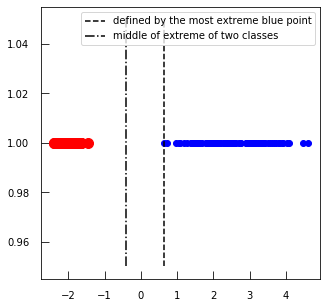

In [57]:
#making dummy dataset 
norm1=0.2*np.random.randn(100)-2
norm2=0.8*np.random.randn(100)+2.5

plt.plot(norm1,[1 for i in range(100)],'ro',markersize=10)
plt.plot(norm2,[1 for i in range(100)],'bo')
s_2=sorted(norm2)
s_1=sorted(norm1)
plt.plot([s_2[0],s_2[0]],[0.95,1.05],'k--',label='defined by the most extreme blue point')
plt.plot([(s_2[0]-s_1[-1])/2+s_1[-1],(s_2[0]-s_1[-1])/2+s_1[-1]],[0.95,1.05],'k-.',label='middle of extreme of two classes')
plt.legend(loc='best')
plt.show()

Here the two hyperplanes are valid separation but you can imagine that the plane define by the most extreme blue point doesn't leave much space for generalization

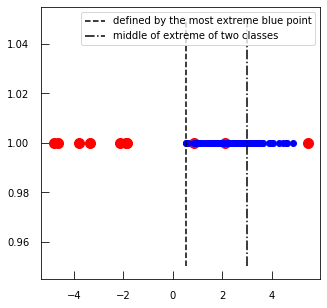

In [59]:
#making dummy dataset non linearly separable
cauch=0.8*np.random.standard_cauchy(10)-2
norm=1*np.random.randn(100)+2.5

plt.plot(cauch,[1 for i in range(10)],'ro',markersize=10)
plt.plot(norm,[1 for i in range(100)],'bo')
sort_c=sorted(cauch)
sort_n=sorted(norm)

plt.plot([sort_n[0],sort_n[0]],[0.95,1.05],'k--',label='defined by the most extreme blue point')
plt.plot([(sort_n[0]-sort_c[-1])/2+sort_c[-1],(sort_n[0]-sort_c[-1])/2+sort_c[-1]],[0.95,1.05],'k-.',label='middle of extreme of two classes')
plt.legend(loc='best')

plt.show()

If your data are not linearly separable you need to be able to choose support vectors that are going to do some missclassification but for the greater good.

We are back to our regularization problem and of course **Support vector machine has a regularization parameter : C**. The game now becomes placing your threshold right in the middle of points (support vectors) from  each classes that you have "chosen" to be general points for decision making : **they don't need to be the two closest points from different classes anymore. They need to be points where your hyperplane makes the least error differantiating classes.**

As stated before, SVM is, at its core, very geometrical and I would like to introduce it a little bit more formally before talking about non linear kernels.

**In the case where you are putting your threshold/hyperplane right in the middle of the two closest points from two different classes (which is a really intuitive thing to do), what you are actually doing is finding a particular hyperplane of the form:**

$\overrightarrow{w}.\overrightarrow{x} - b = 0 $ (or in matricial form if you prefer $w^{T}x-b=0$)

which is particular because it is right in the middle and so maximize the distance between this hyperplane and both the points from the two different classes which are close to each other: that distance is actually $\frac{2}{||\overrightarrow{w}||}$ with of course the norm depending on the scalar product used.

You can see that there is a dot product involved : in the case of a linear hyperplane this dot product is juste the cartesian dot product that you probably use all the time. It allows you to calculate distances between points in that cartesian space or between points and hyperplanes. But you might be familiar with other scalar product : like for example when you proceed to a Fourier decomposition of a function. This particular scalar product acts on functions and so is not really of interest for  us... But others exist.

**So in principle you could use other definitions of distance between points to answer that classification question**. This is what non linear SVM does and this is why you can choose different so called kernels as hyperparameters as we will see below :

$\overrightarrow{x_{i}}.\overrightarrow{x_{j}}$ : cartesian

$(\overrightarrow{x_{i}}.\overrightarrow{x_{j}})^{d}$ : polynomial degree d

$exp(-\gamma||\overrightarrow{x_{i}}-\overrightarrow{x_{j}}||^{2})$ : gaussian radial basis

$tanh(\kappa\overrightarrow{x_{i}}.\overrightarrow{x_{j}}+c)$ : hyperbolic tangent

**This is really powerfull for classification but going non linear by using a kernel trick prevents you to interpret how your features are massaged to create this classifier... So if you want interpretability and do science rather than engineering keep it linear.**

Finally let's look at the analysis part of the problem : what is our loss function here (what do we want to optimize over? Remember for the logistic regression we were maximizing likelihood.)? You want to maximize the distance between your hyperplane and your support vectors. This distance is $\frac{2}{||\overrightarrow{w}||}$. So you want to minimize $||\overrightarrow{w}||$. So you want to minimize $||\overrightarrow{w}||$ with the constrain that most of the points on each side of the hyperplane belong to the same class. This translates into minimizing what is called a hinge loss :

$\frac{1}{m}\Sigma^{m}_{k=1}max(0,1-y_{k}(w^{T}x_{k}-b)) - \frac{1}{C}\Sigma^{n}_{i=1}||w_{i}||^{2}$

Note that you could also use a L1 regularization but it is not implemented in the function we are going to use.

Indeed if most of the data points are well separated in term of class on each side of the hyperplane then most of the time $y_{k}(w^{T}x_{k}-b)=1$ and so $max(0,1-y_{k}(w^{T}x_{k}-b)==0$ (that's good for minimizing our loss function), and a few time $y_{k}(w^{T}x_{k}-b)=-1$ and so $max(0,1-y_{k}(w^{T}x_{k}-b)==2$ (which is polluting our minimization of the loss function).

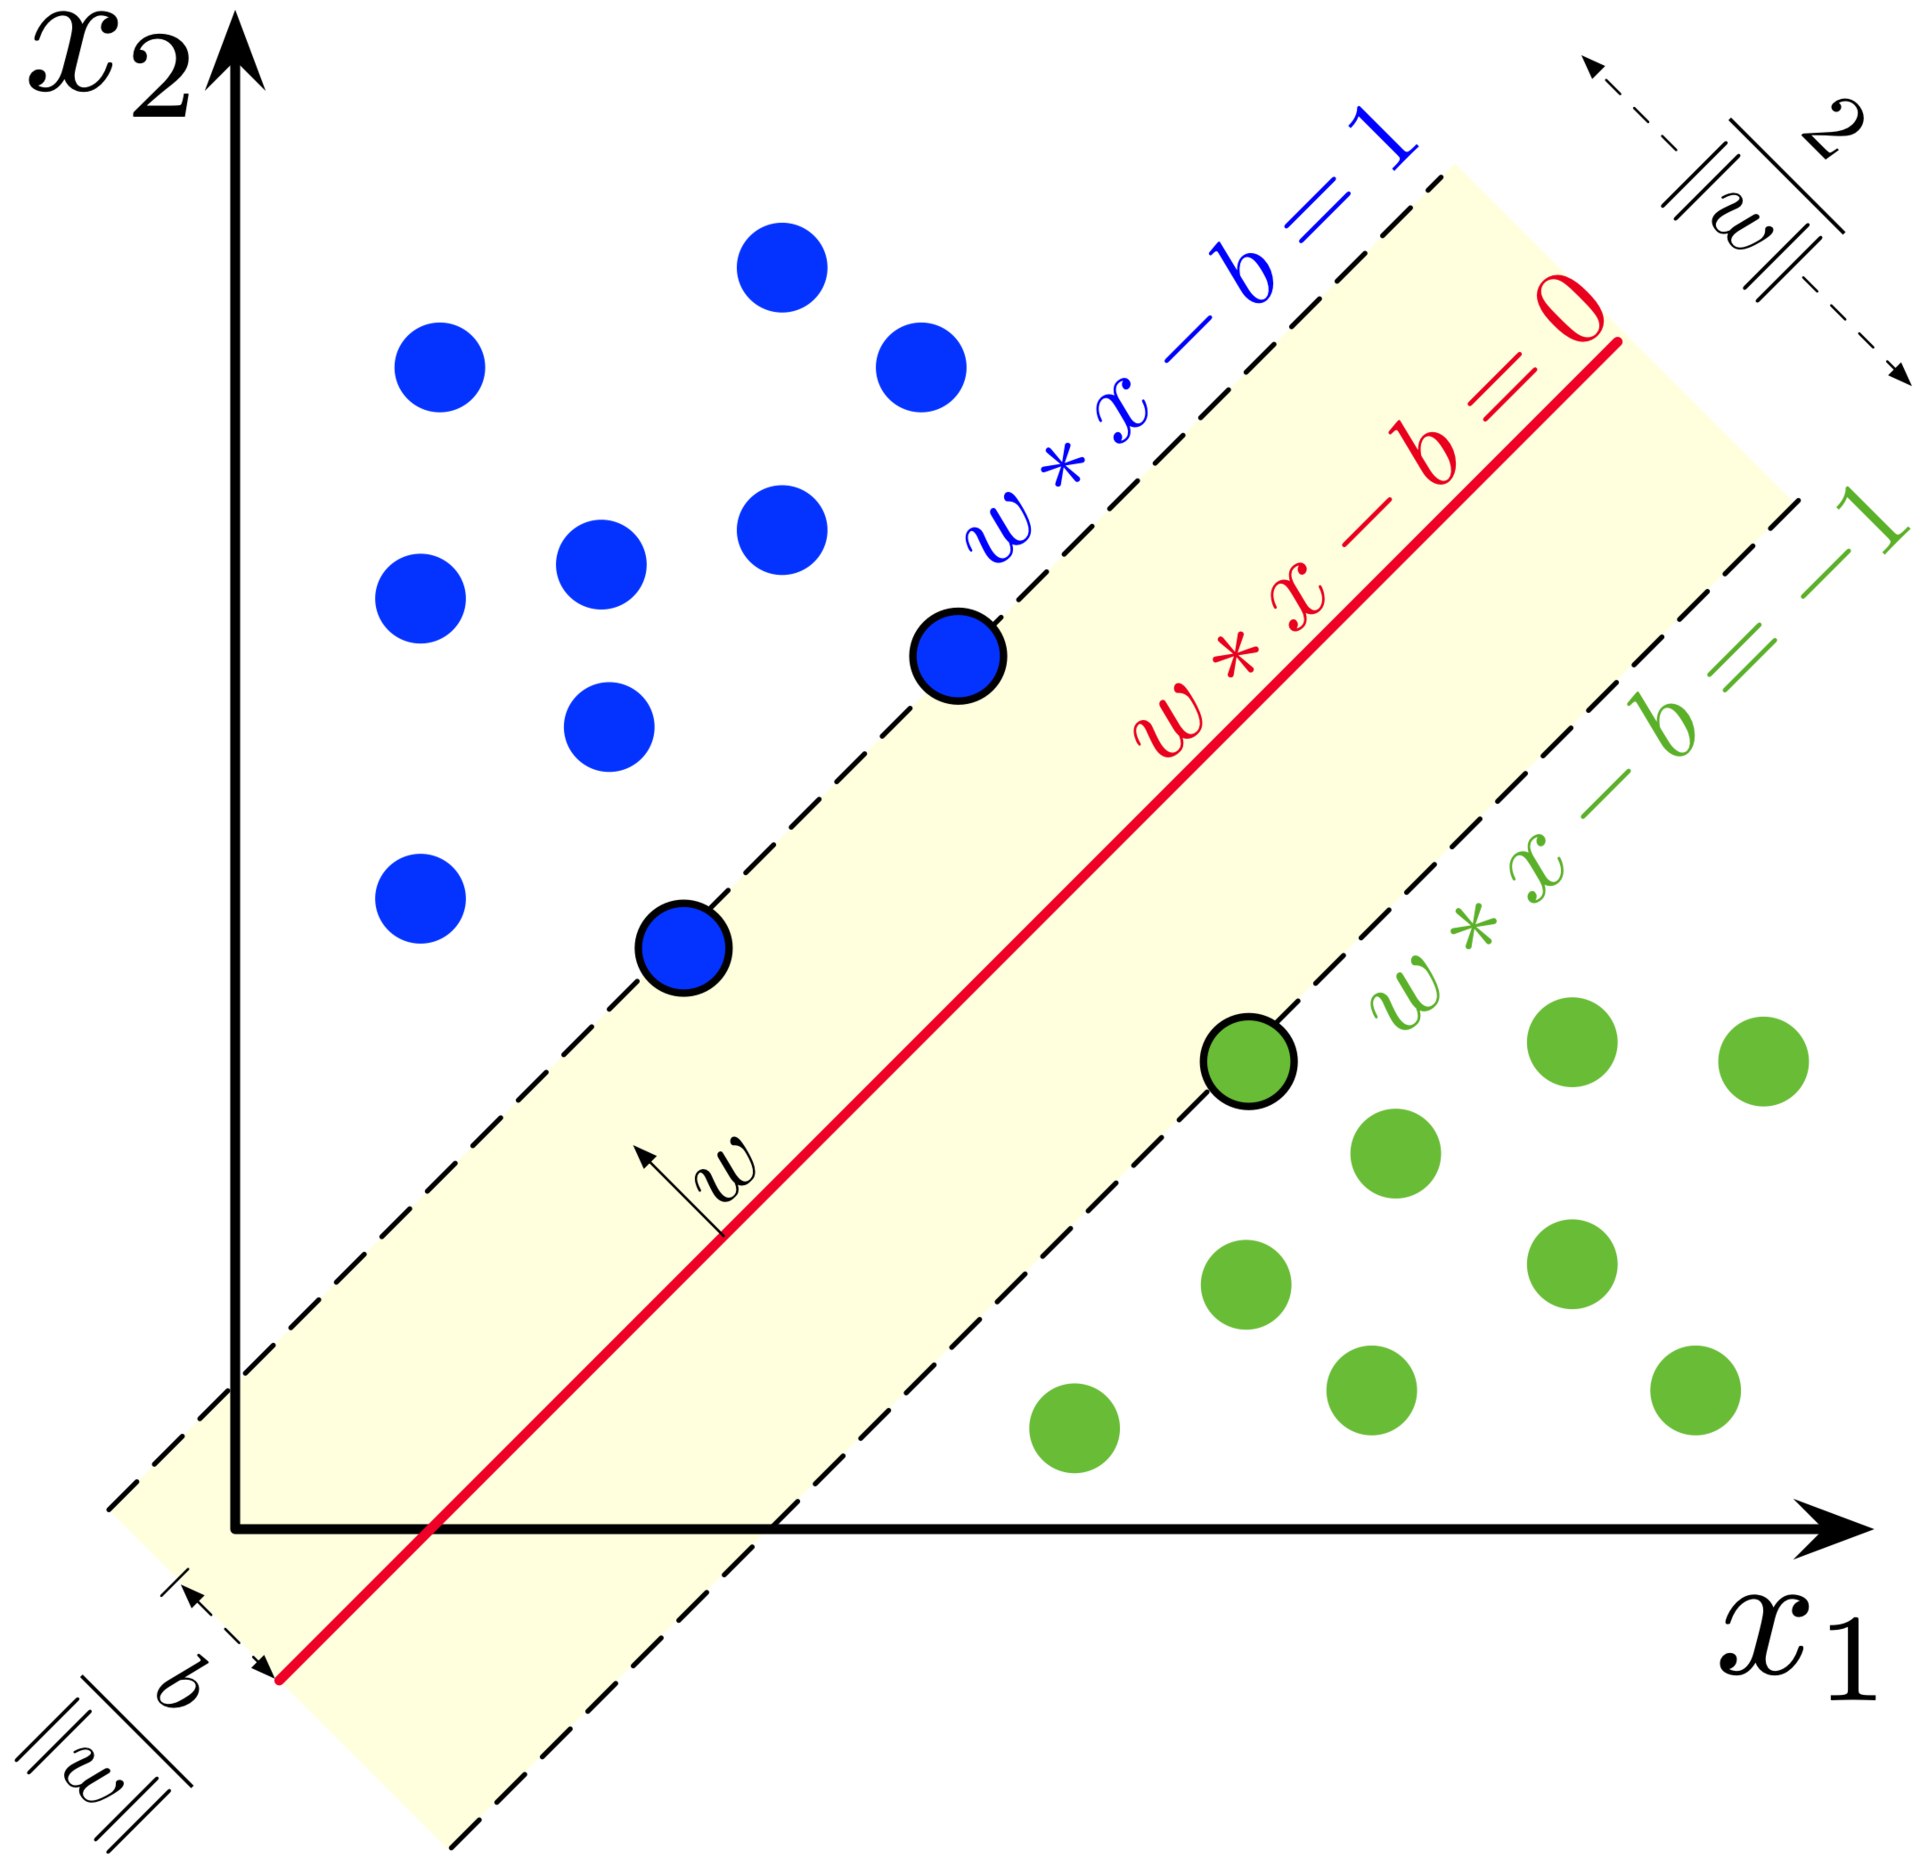

In [60]:
from IPython.display import Image
Image('1920px-SVM_margin.png')

Image source : Wikipedia

Eventhough SVM as nothing to do with probablities, we are going to transform the results of our classifier back to probabilities (using logistic regression...) to be able to draw a ROC curve. But again I insist, those are just usefull transformations but as actually nothing to do with the technique.

### Toy example to visualize SVMC <a class="anchor" id="toy-example-svm-c"></a>

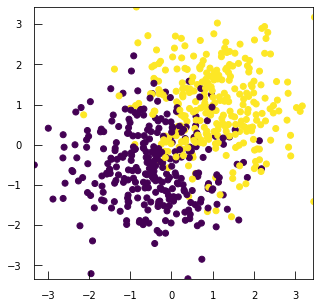

In [62]:


#making toy data

X2, y2 = make_blobs(n_samples=600, centers=[[-0.5,-0.5],[1,1]],cluster_std=[[1,1],[1,1]], random_state=6)


plt.scatter(X2[:,0],X2[:,1],c=y2)
plt.xlim(min(X2[:,1]),max(X2[:,1]))
plt.ylim(min(X2[:,1]),max(X2[:,1]))
plt.show()

[-11.09223357 -11.06853258 -11.04483159 ...   9.36164085   9.38534184
   9.40904284] (212037,) <class 'numpy.ndarray'>


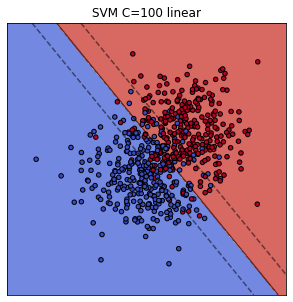

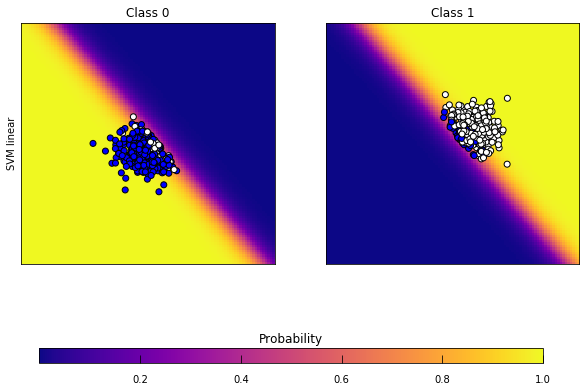

C:\Users\rache\Documents\Advanced_statistics\utils.py:612: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


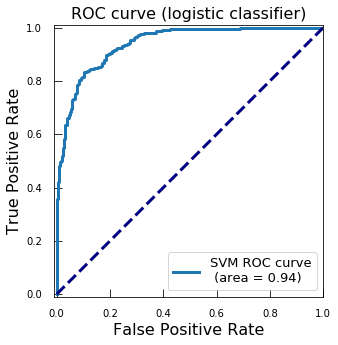

In [63]:
from utils import countour_SVM
countour_SVM(X2,y2,100,'linear',2,1,'ovr')

[-6.75566828 -6.74213354 -6.7285988  ...  5.61277314  5.62630788
  5.63984262] (212037,) <class 'numpy.ndarray'>


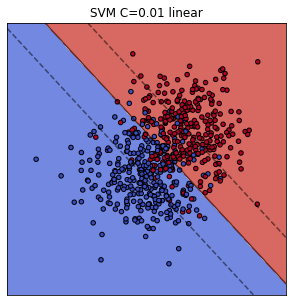

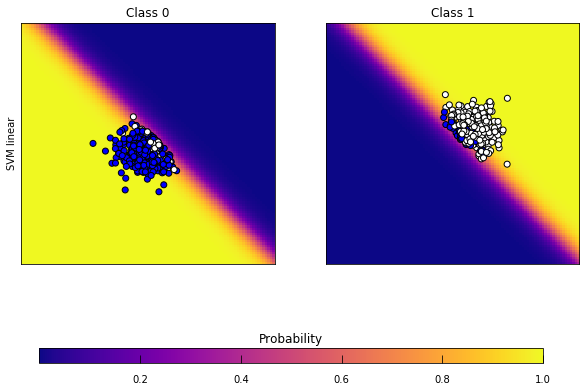

C:\Users\rache\Documents\Advanced_statistics\utils.py:612: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


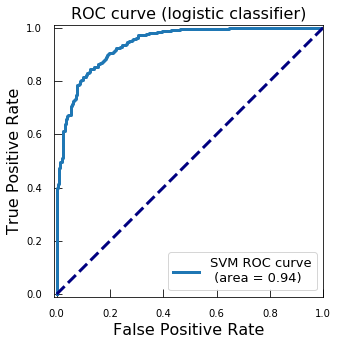

In [64]:
countour_SVM(X2,y2,0.01,'linear',2,1,'ovr')

[-0.04037434 -0.04037434 -0.04037434 ... -0.04037434 -0.04037434
 -0.04037434] (212037,) <class 'numpy.ndarray'>


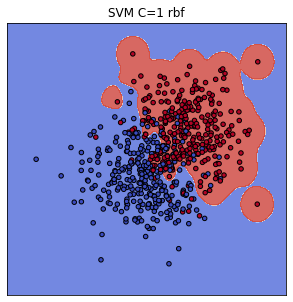

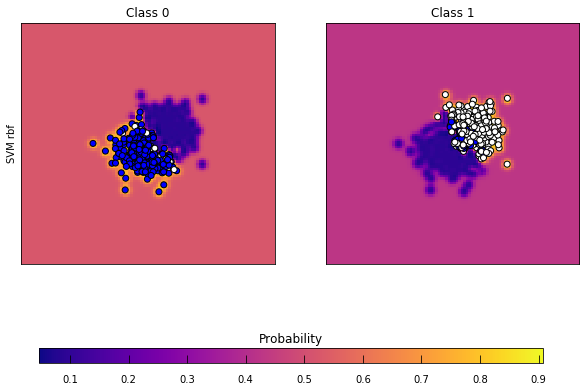

C:\Users\rache\Documents\Advanced_statistics\utils.py:612: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


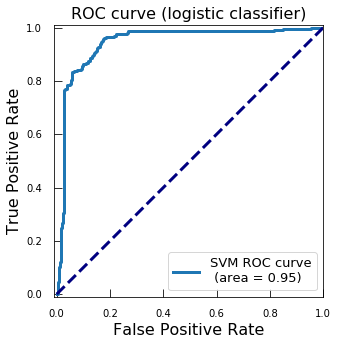

In [65]:
countour_SVM(X2,y2,1,'rbf',2,10,'ovr')

[-0.03369412 -0.03369506 -0.03369613 ...  0.04298096  0.04009143
  0.03725512] (212037,) <class 'numpy.ndarray'>


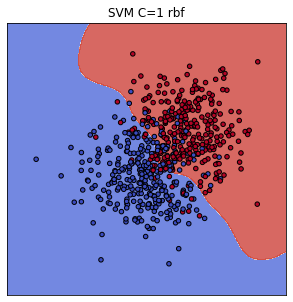

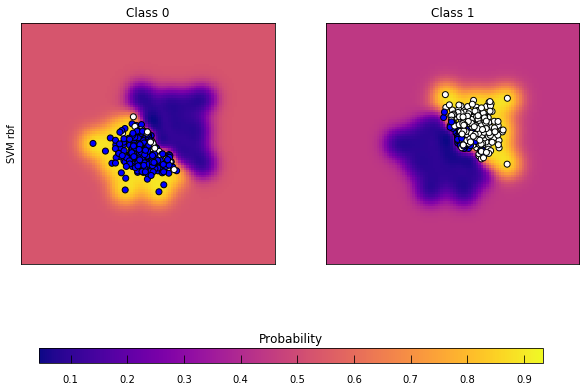

C:\Users\rache\Documents\Advanced_statistics\utils.py:612: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


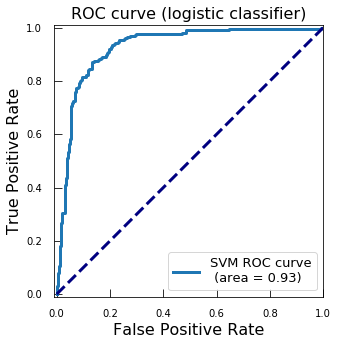

In [66]:
countour_SVM(X2,y2,1,'rbf',2,1,'ovr')

[-361.17682631 -359.07408657 -356.98014843 ...  293.63758202  295.45739481
  297.28534326] (212037,) <class 'numpy.ndarray'>


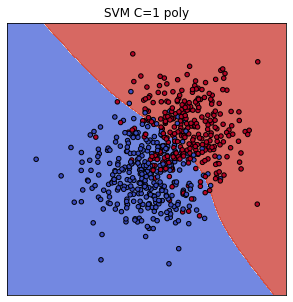

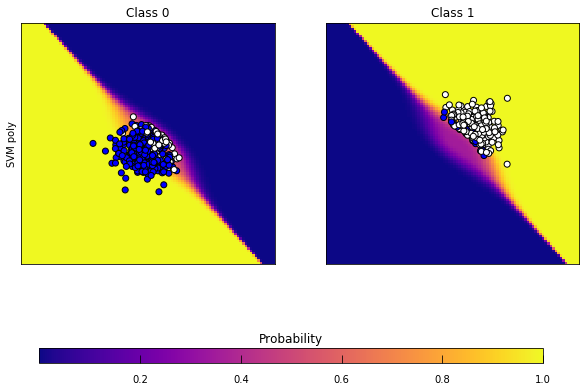

C:\Users\rache\Documents\Advanced_statistics\utils.py:612: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


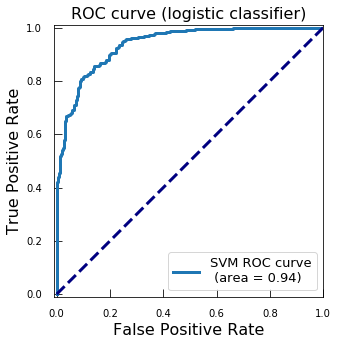

In [67]:
countour_SVM(X2,y2,1,'poly',3,1,'ovr')

### SVMC pipeline. <a class="anchor" id="svm-c-pipeline"></a>

In [68]:
from sklearn.datasets import load_breast_cancer


data = load_breast_cancer()


X2=data['data']
y2=data['target']


fraction of class benign in train 0.6267605633802817 fraction of class benign in test 0.6293706293706294 fraction of class benign in full 0.6274165202108963
Grid best parameter (max.accuracy):  {'model__C': 0.027825594022071243, 'model__degree': 1, 'model__gamma': 10.0, 'model__kernel': 'poly'}
Grid best score (accuracy):  0.9906155950752394
Grid best parameter (max.accuracy) model on test:  0.9440559440559441
confusion matrix
[[48  5]
 [ 3 87]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.92        53
           1       0.95      0.97      0.96        90

    accuracy                           0.94       143
   macro avg       0.94      0.94      0.94       143
weighted avg       0.94      0.94      0.94       143



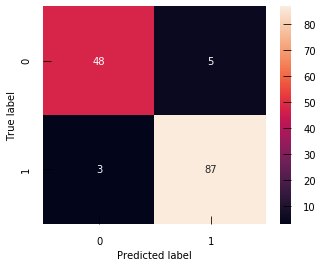

In [70]:
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(X2,y2,
                                                   random_state=0,stratify=y2)


print("fraction of class benign in train",sum(y_train)/len(y_train),"fraction of class benign in test",sum(y_test)/len(y_test),"fraction of class benign in full",sum(y2)/len(y2))


sco='accuracy'

from sklearn.pipeline import Pipeline

#### That's the new part. Now we call SVC instead of logistic regression. Scaling now is a must!
#### We still put the class weight as before, and we add probablity calculation to be able to calculate other score than accuracy
#### like AUC.

pipeline_SVM=Pipeline([('scalar',StandardScaler()),('model',svm.SVC(class_weight='balanced',probability=True))])

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

#### Of course the hyperparameters are SVC specific now.

grid_values = {"model__kernel": ['linear', 'rbf', 'poly'],
                 "model__C":np.logspace(-2, 2, 10),
                 "model__degree":np.arange(0,5,1),
                 "model__gamma": np.logspace(-2,1,10)}


grid_SVM_acc = GridSearchCV(pipeline_SVM, param_grid = grid_values, scoring=sco)

grid_SVM_acc.fit(X_train, y_train)

y_decision_fn_scores_acc=grid_SVM_acc.score(X_test,y_test)

print('Grid best parameter (max.'+sco+'): ', grid_SVM_acc.best_params_)
print('Grid best score ('+sco+'): ', grid_SVM_acc.best_score_)
print('Grid best parameter (max.'+sco+') model on test: ', y_decision_fn_scores_acc)



from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

y_pred_test_c=grid_SVM_acc.predict(X_test)#predict y_test from X_test thanks to your trained model

confusion_mc_c = confusion_matrix(y_test, y_pred_test_c)
print("confusion matrix")
print(confusion_mc_c)
df_cm_c = pd.DataFrame(confusion_mc_c, 
                     index = [i for i in range(2)], columns = [i for i in range(2)])

plt.figure(figsize=(5,4))
sns.heatmap(df_cm_c, annot=True)

plt.ylabel('True label')
plt.xlabel('Predicted label')

print(classification_report(y_test, y_pred_test_c))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


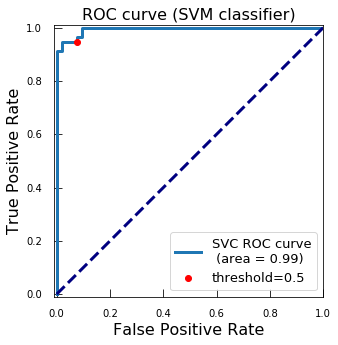

In [71]:
import scipy as sc

y_score_SVM_c = grid_SVM_acc.decision_function(X_test)
fpr_SVM_c, tpr_SVM_c, thre = roc_curve(y_test, y_score_SVM_c)
roc_auc_SVM_c = auc(fpr_SVM_c, tpr_SVM_c)

proba=sc.special.expit(thre)
for i in range(len(proba)):
    if abs(proba[i]-0.5)<0.1:
        keep=i
        break
        

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_SVM_c, tpr_SVM_c, lw=3, label='SVC ROC curve\n (area = {:0.2f})'.format(roc_auc_SVM_c))
plt.plot(fpr_SVM_c[keep], tpr_SVM_c[keep],'ro',label='threshold=0.5')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (SVM classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

In [72]:
from operator import itemgetter
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

SVM = svm.SVC(kernel='linear',C=0.01,class_weight='balanced',probability=True)
SVM.fit(X_train_scaled, y_train)
w=SVM.coef_[0]#get the weights

sorted_features=sorted([[data["feature_names"][i],abs(w[i])] for i in range(len(w))],key=itemgetter(1),reverse=True)

print('Features sorted per importance in discriminative process')
print(sorted_features)

Features sorted per importance in discriminative process
[['worst texture', 0.2181329070228791], ['worst radius', 0.21557233113130478], ['worst concave points', 0.20160909812742372], ['worst perimeter', 0.20115201768219146], ['worst area', 0.18929558024141388], ['mean radius', 0.1777184781156021], ['mean concave points', 0.17344141101741128], ['mean perimeter', 0.17158522612548396], ['mean area', 0.16838994471475566], ['worst smoothness', 0.15310972082058896], ['mean texture', 0.14740896004272164], ['mean concavity', 0.13987753993438248], ['worst symmetry', 0.1362312181082094], ['worst concavity', 0.12766825349100364], ['radius error', 0.12200523001425127], ['mean fractal dimension', 0.10721026619197696], ['area error', 0.10698965092623534], ['worst fractal dimension', 0.08391943752779862], ['perimeter error', 0.08319818725048282], ['symmetry error', 0.0768743190926525], ['worst compactness', 0.06361814306330747], ['smoothness error', 0.05676261238720846], ['compactness error', 0.05535

## Regression <a class="anchor" id="svm-r"></a>

We could use the same algorithm for regression, with the only difference that this time instead of finding the hyperplane that is the farthest from the support, we find the hyperplane that is the closest from those support. Do it for our diabete data set, just by replacing SVC by SVR. Just use the gamma kernel.

In [73]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()

df_diabetes=pd.DataFrame([[diabetes['data'][j,i] for i in range(len(diabetes['feature_names'])) if diabetes['feature_names'][i]!="sex"] for j in range(diabetes['data'].shape[0])],
                         columns=[diabetes['feature_names'][i] for i in range(len(diabetes['feature_names']))if diabetes['feature_names'][i]!="sex"])
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from operator import itemgetter
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split


X_diabetes_train, X_diabetes_test, y_diabetes_train, y_diabetes_test = train_test_split(np.array(df_diabetes), np.array(diabetes['target']),
                                                   random_state=0)


sco='r2'

from sklearn.pipeline import Pipeline

#### Use SVR instead of SVC

pipeline_SVR=Pipeline([('scalar',StandardScaler()),('model',svm.SVR())])

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

#### It was too long to do a big gridsearch so I focused on rbf kernel

grid_values = {"model__kernel": ['rbf'],#['linear', 'rbf', 'poly'],
                 "model__C":np.logspace(-2, 2, 20),
                 #"model__degree":np.arange(0,5,1),
                 "model__gamma": np.logspace(-2,2,20)}


grid_SVR_acc = GridSearchCV(pipeline_SVR, param_grid = grid_values, scoring=sco)

grid_SVR_acc.fit(X_diabetes_train, y_diabetes_train)

y_decision_fn_scores_acc=grid_SVR_acc.score(X_diabetes_test,y_diabetes_test)

print('Grid best parameter (max.'+sco+'): ', grid_SVR_acc.best_params_)
print('Grid best score ('+sco+'): ', grid_SVR_acc.best_score_)
print('Grid best parameter (max.'+sco+') model on test: ', y_decision_fn_scores_acc)





Grid best parameter (max.r2):  {'model__C': 23.357214690901213, 'model__gamma': 0.04281332398719394, 'model__kernel': 'rbf'}
Grid best score (r2):  0.5104055389989391
Grid best parameter (max.r2) model on test:  0.32026953320708174


Unfortunately because of the non linear transformation involved in the RBF kernel we can not interpret the fit in terms of the covariables/features.

In [74]:
pipeline_SVR=Pipeline([('scalar',StandardScaler()),('model',svm.SVR())])

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

grid_values = {"model__kernel": ['poly'],#['linear', 'rbf', 'poly'],
                 "model__C":np.logspace(-2, 2, 20),
                 "model__degree":np.arange(0,5,1)}#,
                 #"model__gamma": np.logspace(-2,1,5)}

grid_SVR_acc = GridSearchCV(pipeline_SVR, param_grid = grid_values, scoring=sco)

grid_SVR_acc.fit(X_diabetes_train, y_diabetes_train)

y_decision_fn_scores_acc=grid_SVR_acc.score(X_diabetes_test,y_diabetes_test)
print('Grid best parameter (max.'+sco+'): ', grid_SVR_acc.best_params_)
print('Grid best score ('+sco+'): ', grid_SVR_acc.best_score_)
print('Grid best parameter (max.'+sco+') model on test: ', y_decision_fn_scores_acc)


Grid best parameter (max.r2):  {'model__C': 14.38449888287663, 'model__degree': 1, 'model__kernel': 'poly'}
Grid best score (r2):  0.4879440753327223
Grid best parameter (max.r2) model on test:  0.3302365970646919


# Decision tree modeling : a new? loss function and new ways to do regularization. <a class="anchor" id="decision-tree"></a>

## Simple decision tree for classification. <a class="anchor" id="simple-tree-c"></a>

**A simple decision tree reduces your probleme into a hierarchichal sequence of questions on your features that can be answered by yes or no and that subdivises the data into 2 subgroups on which a new question is asked, and so on and so on.**

Ok but a huge number of trees can actually be built just by considering the diffrent orders of questions asked. How does the algo deal with this?

Quite simply actually. **It tests all the features and chooses the best discriminative (in terms of your labels) features to divide the data into 2 subsets of data that answered yes or no to the question.** Then on those subsets the algo chooses again the most discriminative feature. How do you discriminate? By calculating an impurity : meaning how much your feature splitting is still having mix classes. Note that impurity then goes through function to give a score : either it is a simple Shannon entropy or it is a Gini entropy.

Imagine you have a dataset with feature color(red or blue) and feature shape(square or circle), and 2 classes (1,2):

If answering True to feature color is red gives you a subgroup of 10 class 1 and 1 class 2 and, False gives you 2 class 1 and 11 class 2 then it is a better classifier than:

feature shape is square that gives you a subgroup of 5 class 1 and 7 class 2 and, circle give you 7 class 1 and 5 class 2


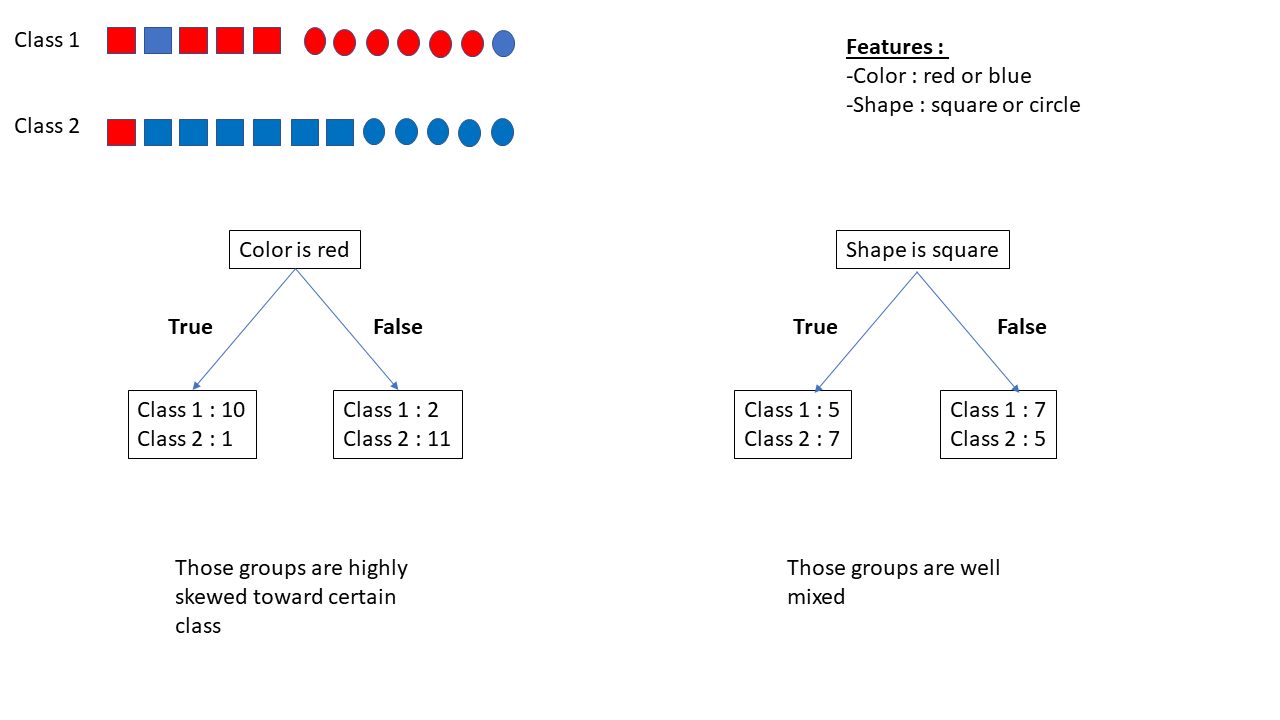

In [75]:
from IPython.display import Image
Image('Tree.png')

**The points are better separated in terms of their classes by answering True or False for feature color than for feature shape.** Some of you could already see that entropy calculation could be a good way to summarize all that text above, hence my little aparte about impurity before. This is also why there is a question mark in the title.

**This is something "easy" to visualize if your features are categorical like 'yellow' but if they are numeric features like weights, how do you transform that to a yes/no questions? By choosing a threshold...** But how do you choose the threshold? Again you find the threshold by chooisng the number with the minimum impurity. When you have a threshold for each feature then you can compare their impurity. You will have to compute this threshold at each step of your tree since at each step you are considering different subdatasets.


Before going further, just a little bit of vocabulary. Trees are made of nodes (where the question is asked and where the splitting occurs). A branch is the outcome of a splitting. A leaf is the last node on a branch (no more splitting).
### Toy example to visualize decision tree. <a class="anchor" id="toy-decision-tree"></a>

Let explore some hyperparamters of this method that, you will see in those exemples, act like a regularization:
- Max Tree depth: the maximum number of consecutive questions to ask
- Min Splitting of nodes: the minimum number of point that should be considered to make a new rule, outside of the leaves
- Min Splitting of leaves: the minimum number of point that should be considered to make a new rule at the leaves

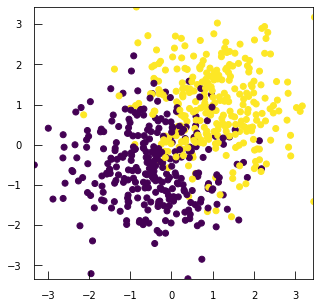

In [76]:
from sklearn.datasets import make_blobs



X2, y2 = make_blobs(n_samples=600, centers=[[-0.5,-0.5],[1,1]],cluster_std=[[1,1],[1,1]], random_state=6)


plt.scatter(X2[:,0],X2[:,1],c=y2)
plt.xlim(min(X2[:,1]),max(X2[:,1]))
plt.ylim(min(X2[:,1]),max(X2[:,1]))
plt.show()

In [6]:
#only for graphical representation of the trees : you don't need it for analysis.
#you will need to pip install pydotplus the first time so just remove the # signe
#!pip install pydotplus
#You will need graphviz lib also. Download it here : https://graphviz.gitlab.io/download/
#You will need to add it to your python path
import os
os.environ["PATH"] += os.pathsep + 'C:/graphviz-2.38/release/bin/'#path where you installed it

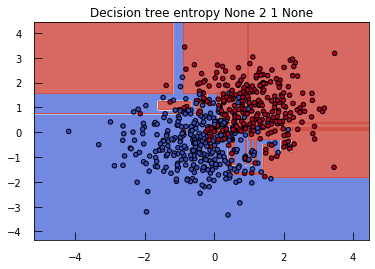

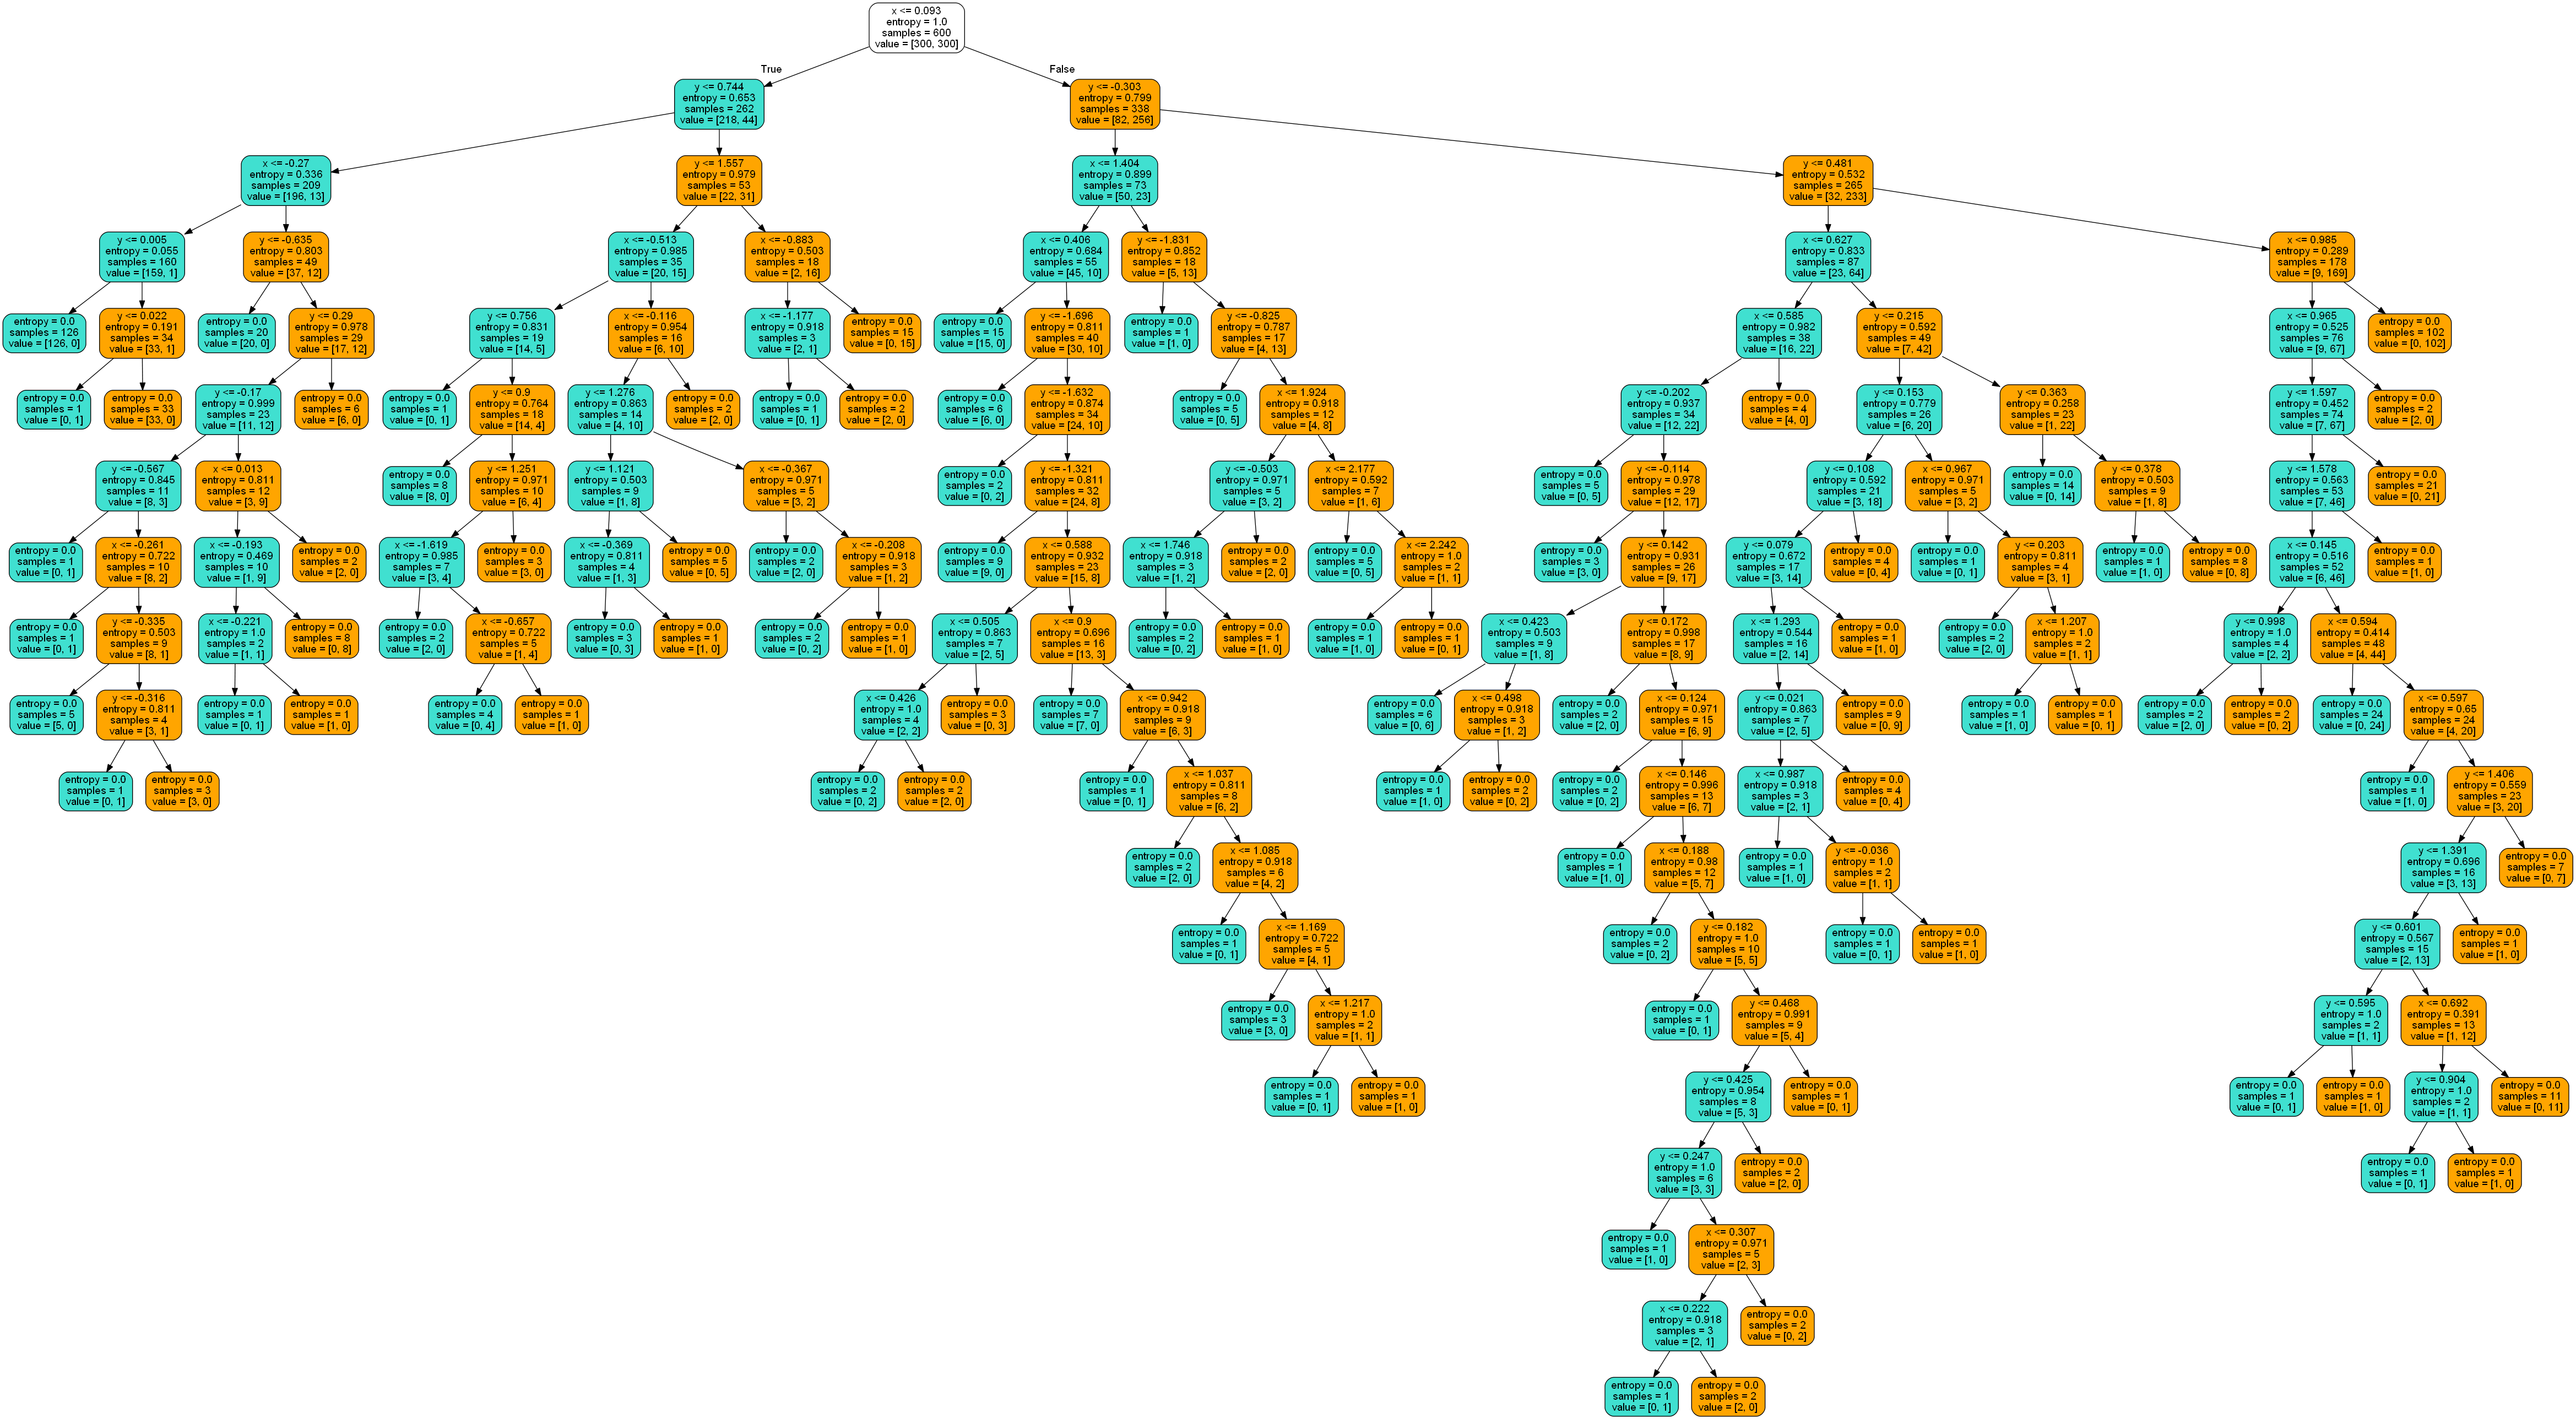

In [7]:
from utils import countour_tree

countour_tree(X2,y2,'entropy',None,2,1,None)#You can see that there are 5 hyperparameters here. Let's see what they do 
#and what they mean. I bet you can already guess it is going to be related to regularization....
#After X,y you have 'entropy' which is one way to calculate impurity (you could also put gini here), then the max depth of your
#tree, then the number of points that should be concerned by the making of a new rule (splitting of the nodes), and the number
#of points that should be considered to make a final leaf classification. Finally the last one is maximum number of features
#to consider for making a new rule...

This is an incredibly complex model. 

Please, note that since every node is a question asked on one particular feature and features are never directly compared, you don't need scaling! This observation that each question always involves one feature at a time can be also seen in the way the boundaries between classes are made in the graph : there is no diagonal boundaries. You can only see lines parallel to the plot axes.

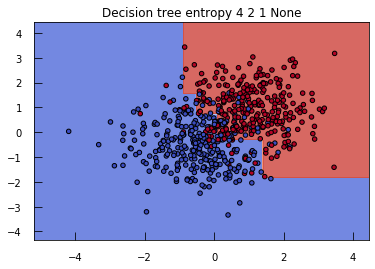

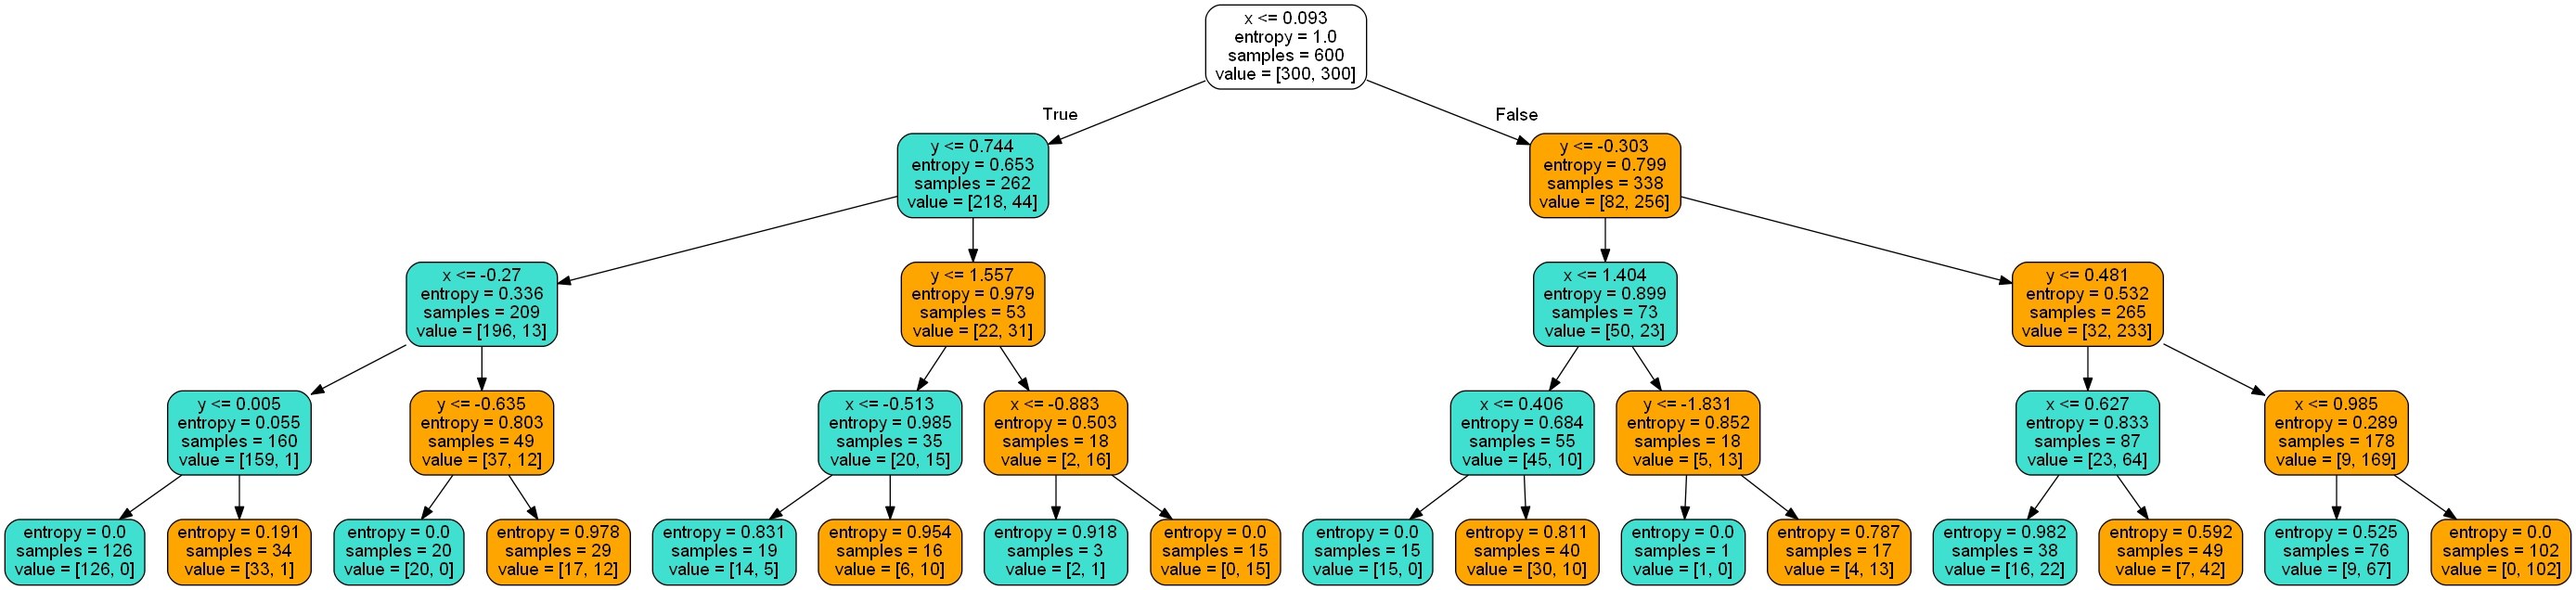

In [14]:
countour_tree(X2,y2,'entropy',4,2,1,None)

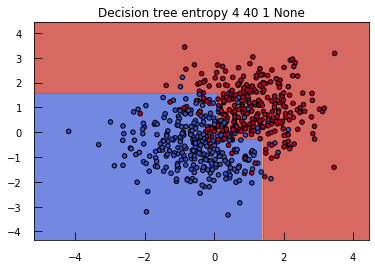

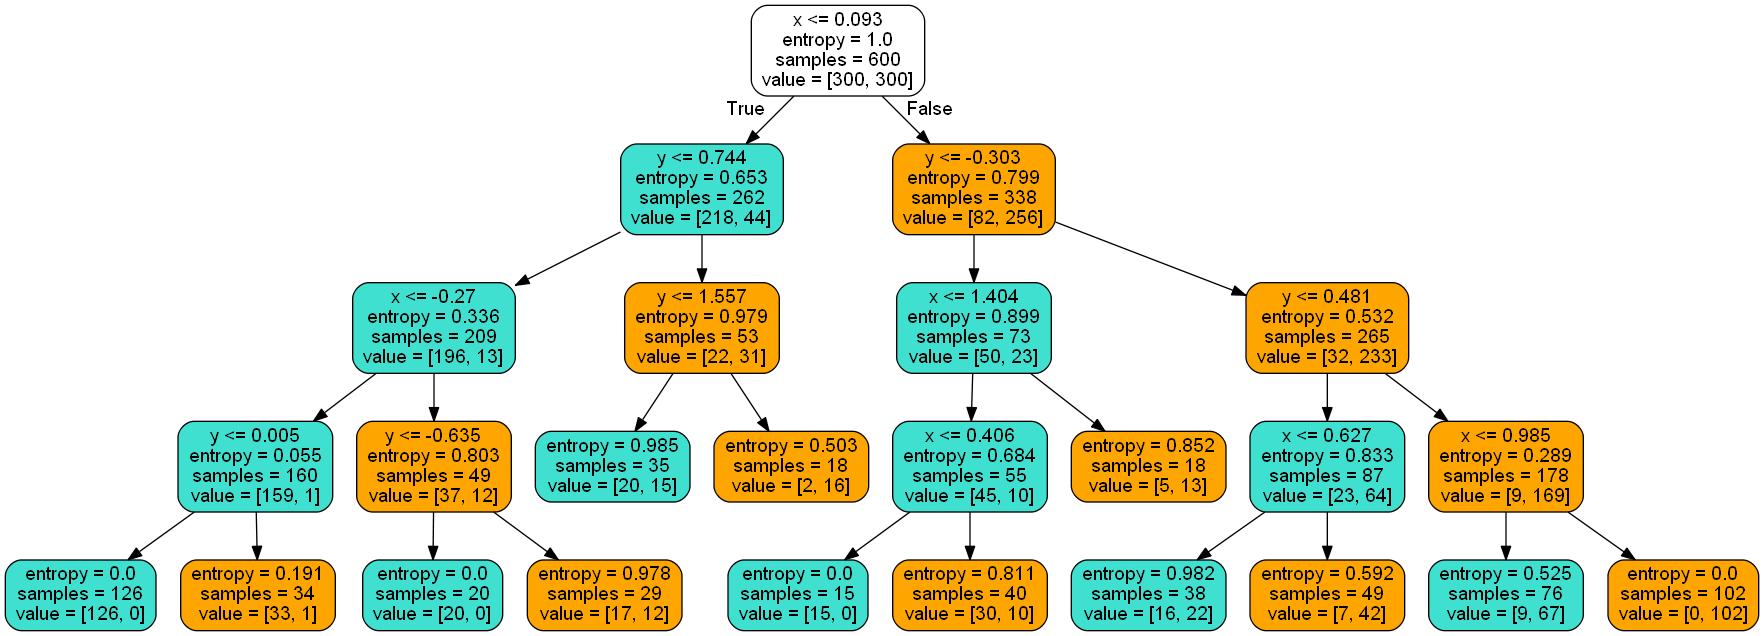

In [19]:
countour_tree(X2,y2,'entropy',4,40,1,None)# I don't really have a feeling of where I should stop the tree depth. But I have
#an understanding of this other parameter (here set to 40) called min_samples_leaf : it sets the minimal number of data points
#that the overall chain of rules should concern. Do you really care of making a whole new set of rules to explain only one
#particular data point? 

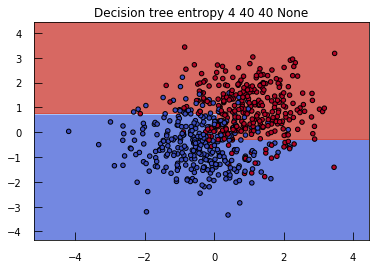

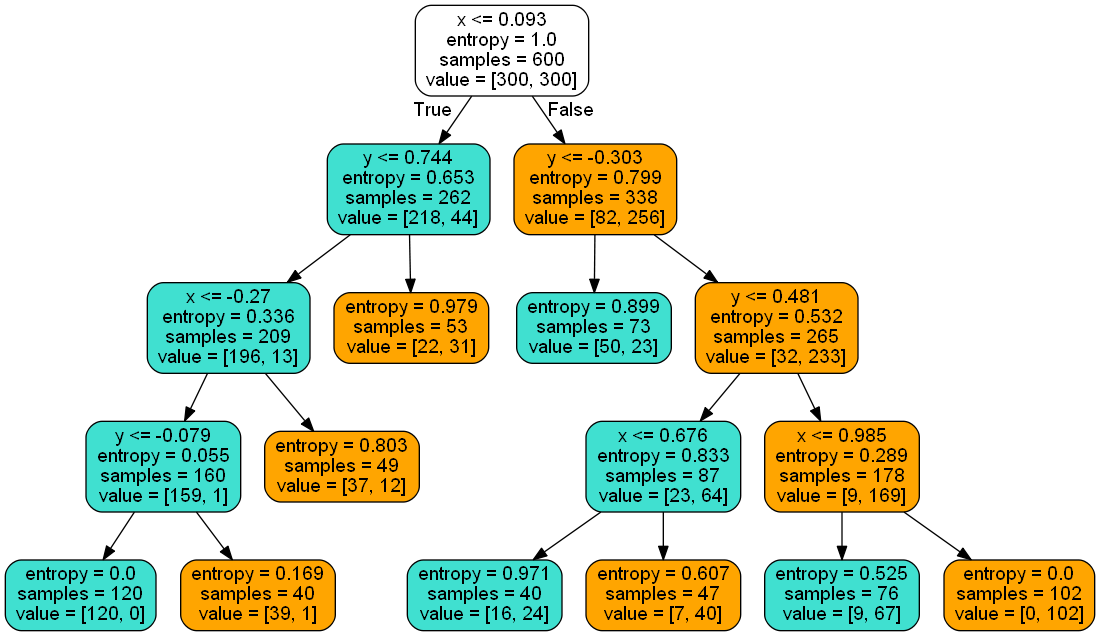

In [20]:
countour_tree(X2,y2,'entropy',4,40,40,None)

**The interesting thing with this kind of method is that it works with all types of features (numerical or class, I mean in theory), you don't need to rescale and it already includes non linear fitting. Moreover it is 'easy' to interpret.** 

But....(yes there is a but, there is no free lunch)

**Even with all of those hyperparamaters they are still not great on new data (inacuracy....).** We will see that in the real data example below and we will see more powerful technics based on decision trees that are more costly but generalize better.

### Single decision tree pipeline. <a class="anchor" id="single-tree-pipeline"></a>

Grid best parameter (max. accuracy):  {'criterion': 'entropy', 'max_depth': 82, 'min_samples_leaf': 1, 'min_samples_split': 2}
Grid best score (accuracy):  0.9436388508891931
Grid best parameter (max. accuracy) model on test:  0.951048951048951
              precision    recall  f1-score   support

           0       0.90      0.98      0.94        53
           1       0.99      0.93      0.96        90

    accuracy                           0.95       143
   macro avg       0.94      0.96      0.95       143
weighted avg       0.95      0.95      0.95       143



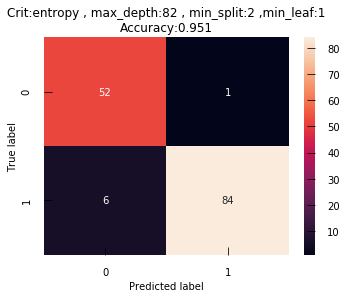

In [78]:

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split

from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
df_cancer = pd.concat([pd.DataFrame(cancer['data'],columns=cancer['feature_names']),\
                       pd.DataFrame(cancer['target'],columns=['malignant'])],axis=1)

(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

X_cancer_train, X_cancer_test, y_cancer_train, y_cancer_test = train_test_split(X_cancer, y_cancer,
                                                   random_state=0)


from sklearn.metrics import confusion_matrix,accuracy_score

#### We use DecisionTreeClassifier with the different hyperparameters we want to explore

grid_values = {'criterion': ['entropy','gini'],
               'max_depth':np.arange(2,len(X_cancer_train),20),
               'min_samples_split':np.arange(2,len(X_cancer_train),20),
              'min_samples_leaf':np.arange(1,len(X_cancer_train),20)}

grid_tree_acc = GridSearchCV(DecisionTreeClassifier(class_weight="balanced"), param_grid = grid_values, scoring='accuracy')
grid_tree_acc.fit(X_cancer_train, y_cancer_train)

y_decision_fn_scores_acc=grid_tree_acc.score(X_cancer_test,y_cancer_test)

print('Grid best parameter (max. accuracy): ', grid_tree_acc.best_params_)
print('Grid best score (accuracy): ', grid_tree_acc.best_score_)
print('Grid best parameter (max. accuracy) model on test: ', y_decision_fn_scores_acc)

y_pred_test_c=grid_tree_acc.predict(X_cancer_test)

confusion_mc_c = confusion_matrix(y_cancer_test, y_pred_test_c)
df_cm_c = pd.DataFrame(confusion_mc_c, 
                     index = [i for i in range(0,len(cancer['target_names']))], columns = [i for i in range(0,len(cancer['target_names']))])

plt.figure(figsize=(5.5,4))
sns.heatmap(df_cm_c, annot=True)
plt.title('Crit:'+str(grid_tree_acc.best_params_['criterion'])
          +' , max_depth:'+str(grid_tree_acc.best_params_['max_depth'])+' , min_split:'+str(grid_tree_acc.best_params_['min_samples_split'])+
          ' ,min_leaf:'+str(grid_tree_acc.best_params_['min_samples_leaf'])
          +'\nAccuracy:{0:.3f}'.format(accuracy_score(y_cancer_test, 
                                                                       y_pred_test_c)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

print(classification_report(y_cancer_test, y_pred_test_c))

That's an awfully complicated model that is performing similarly to other models trained before.

In [79]:
from operator import itemgetter
tree = DecisionTreeClassifier(criterion=grid_tree_acc.best_params_['criterion'],
                             max_depth=grid_tree_acc.best_params_['max_depth'],
                             min_samples_leaf=grid_tree_acc.best_params_['min_samples_leaf'],
                             min_samples_split=grid_tree_acc.best_params_['min_samples_split'])
tree.fit(X_cancer_train, y_cancer_train)
w=tree.feature_importances_#get the weights

sorted_features=sorted([[cancer['feature_names'][i],abs(w[i])] for i in range(len(w))],key=itemgetter(1),reverse=True)

print('Features sorted per importance in discriminative process')
print(sorted_features)

Features sorted per importance in discriminative process
[['mean concave points', 0.5996207956577764], ['worst perimeter', 0.10714713442345987], ['worst radius', 0.0925513562378589], ['worst texture', 0.06962292629168856], ['mean texture', 0.03397069859524919], ['worst symmetry', 0.032593535854225225], ['area error', 0.022576792574110695], ['worst compactness', 0.01477715697923311], ['mean radius', 0.01236244640716487], ['worst area', 0.007992256132633614], ['mean concavity', 0.0067849008465994945], ['mean perimeter', 0.0], ['mean area', 0.0], ['mean smoothness', 0.0], ['mean compactness', 0.0], ['mean symmetry', 0.0], ['mean fractal dimension', 0.0], ['radius error', 0.0], ['texture error', 0.0], ['perimeter error', 0.0], ['smoothness error', 0.0], ['compactness error', 0.0], ['concavity error', 0.0], ['concave points error', 0.0], ['symmetry error', 0.0], ['fractal dimension error', 0.0], ['worst smoothness', 0.0], ['worst concavity', 0.0], ['worst concave points', 0.0], ['worst frac

## Random Forest in classification. <a class="anchor" id="rf-c"></a>

**Random Forest algorithm relies on two main concepts : producing/training many trees all different from an element of randomness, and then asking all the trees what their prediction on new points is and choose a way to agglomerate those different predicitions (mainly averaging).** 

Those elements of randomness concern the **training dataset via bootstrapping methods** and also only using a **random subset of features for creating the trees in the forest** (this is different from setting a max_feature this time!). Each  bootstrap part is going to be used to **train a new tree in the forest** (and this tree will be build only with the randomly drawn subset of parameters).

**Bootstrapping methods are sampling methods in which you randomly draw a subsample of your data**. You keep the same size as the initial data though. This is possible because duplicates of points are allowed. This subsample is then used to train a tree which will have also a subsample of the features only. 

I am sure you can see intuitively how that is going to help the generalization of our model.

So now you have all the parameters seen before for individually creating each tree of the forest, but you also have a parameter controlling the number of trees in your forest.


**In the following plots I am plotting the result for a random forest algorithm and compare it to a single decision tree sharing the same hyperparameters value than the one used in the random forest**.




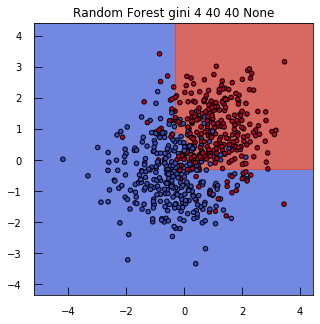

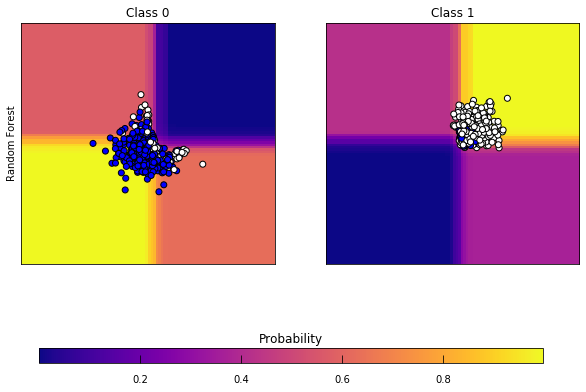

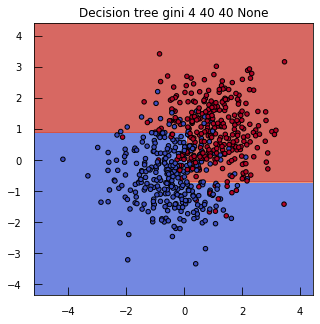

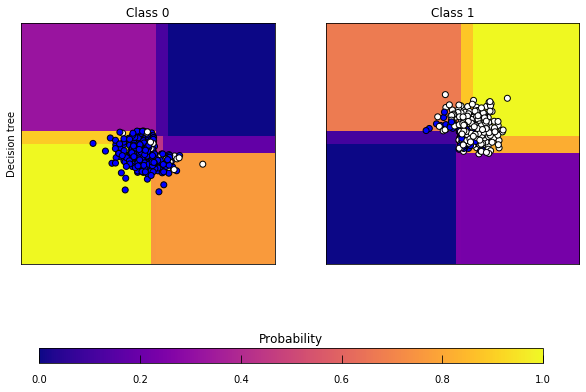

In [80]:
from utils import countour_RF
countour_RF(X2,y2,100,'gini',4,40,40,None)#Same as for decision tree except that we have here one more hyperparameter, here
#put to 100 and that represents the number of bootstraps (number of trees trained and then participating to the vote)

Grid best parameter (max. accuracy):  {'criterion': 'entropy', 'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 101}
Grid best score (accuracy):  0.9531053351573189
Grid best parameter (max. accuracy) model on test:  0.965034965034965


Text(0.5, 10.0, 'Predicted label')

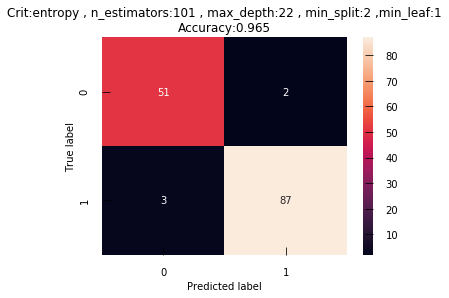

In [83]:
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestClassifier

##### Now we use RandomForestClassifier
grid_values = {'criterion': ['entropy','gini'],
               'n_estimators':np.arange(1,500,100), 
               'max_depth':np.arange(2,int(len(X_cancer_train)/10),20),
               'min_samples_split':np.arange(2,int(len(X_cancer_train)/10),20),
              'min_samples_leaf':np.arange(1,int(len(X_cancer_train)/10),20)}

grid_tree_acc = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid = grid_values, scoring='accuracy')

grid_tree_acc.fit(X_cancer_train, y_cancer_train)

y_decision_fn_scores_acc=grid_tree_acc.score(X_cancer_test,y_cancer_test)

print('Grid best parameter (max. accuracy): ', grid_tree_acc.best_params_)
print('Grid best score (accuracy): ', grid_tree_acc.best_score_)

print('Grid best parameter (max. accuracy) model on test: ', y_decision_fn_scores_acc)

y_pred_test_c=grid_tree_acc.predict(X_cancer_test)

confusion_mc_c = confusion_matrix(y_cancer_test, y_pred_test_c)
df_cm_c = pd.DataFrame(confusion_mc_c, 
                     index = [i for i in range(0,len(cancer['target_names']))], columns = [i for i in range(0,len(cancer['target_names']))])

plt.figure(figsize=(5.5,4))
sns.heatmap(df_cm_c, annot=True)
plt.title('Crit:'+str(grid_tree_acc.best_params_['criterion'])
          +' , n_estimators:'+str(grid_tree_acc.best_params_['n_estimators'])
          +' , max_depth:'+str(grid_tree_acc.best_params_['max_depth'])+' , min_split:'+str(grid_tree_acc.best_params_['min_samples_split'])+
          ' ,min_leaf:'+str(grid_tree_acc.best_params_['min_samples_leaf'])
          +'\nAccuracy:{0:.3f}'.format(accuracy_score(y_cancer_test, 
                                                                       y_pred_test_c)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [84]:
print(classification_report(y_cancer_test, y_pred_test_c))

RF = RandomForestClassifier(criterion=grid_tree_acc.best_params_['criterion'],
                              n_estimators=grid_tree_acc.best_params_['n_estimators'],
                             max_depth=grid_tree_acc.best_params_['max_depth'],
                             min_samples_leaf=grid_tree_acc.best_params_['min_samples_leaf'],
                             min_samples_split=grid_tree_acc.best_params_['min_samples_split'])
RF.fit(X_cancer_train, y_cancer_train)
w=RF.feature_importances_#get the weights

sorted_features=sorted([[cancer['feature_names'][i],abs(w[i])] for i in range(len(w))],key=itemgetter(1),reverse=True)

print('Features sorted per importance in discriminative process')
print(sorted_features)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95        53
           1       0.98      0.97      0.97        90

    accuracy                           0.97       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.97      0.97      0.97       143

Features sorted per importance in discriminative process
[['mean concave points', 0.13469909376069056], ['worst concave points', 0.11986162912699196], ['worst perimeter', 0.0963585992959648], ['worst radius', 0.0955541020565723], ['worst area', 0.09484272259527231], ['area error', 0.05569698600361997], ['mean perimeter', 0.054825650856598206], ['mean concavity', 0.047943478175554805], ['worst concavity', 0.03352977085712034], ['mean radius', 0.0323130729325632], ['worst compactness', 0.027312982982675794], ['radius error', 0.02601130728542419], ['mean texture', 0.021615237091688597], ['worst texture', 0.019827816450228644], ['worst smoothness', 0.015371984547641947

## Radom Forest in regression. <a class="anchor" id="rf-r"></a>

The only difference is now the split is made according to mean sqaure error or mean absolute error, instead of entropy or Gini.

In [85]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()

df_diabetes=pd.DataFrame([[diabetes['data'][j,i] for i in range(len(diabetes['feature_names'])) if diabetes['feature_names'][i]!="sex"] for j in range(diabetes['data'].shape[0])],
                         columns=[diabetes['feature_names'][i] for i in range(len(diabetes['feature_names']))if diabetes['feature_names'][i]!="sex"])
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from operator import itemgetter
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split


X_diabetes_train, X_diabetes_test, y_diabetes_train, y_diabetes_test = train_test_split(np.array(df_diabetes), np.array(diabetes['target']),
                                                   random_state=0)


In [86]:
from sklearn.ensemble import RandomForestRegressor
grid_values = {'criterion': ['mse'],
               'n_estimators':np.arange(1,500,50), 
               'max_depth':np.arange(2,int(len(X_diabetes_train)),20),
               'min_samples_split':np.arange(2,int(len(X_diabetes_train)/5),20),
              'min_samples_leaf':np.arange(1,int(len(X_diabetes_train)/5),20)}

grid_tree_acc = GridSearchCV(RandomForestRegressor(), param_grid = grid_values, scoring='r2')

grid_tree_acc.fit(X_diabetes_train, y_diabetes_train)

y_decision_fn_scores_acc=grid_tree_acc.score(X_diabetes_test,y_diabetes_test)

print('Grid best parameter (max. r2): ', grid_tree_acc.best_params_)
print('Grid best score (r2): ', grid_tree_acc.best_score_)
print('Grid best parameter (max. r2) model on test: ', y_decision_fn_scores_acc)


KeyboardInterrupt: 

# Exo : regression <a class="anchor" id="exo-regression"></a>

In [87]:
features = pd.read_csv('One_hot_temp.csv')
features.head(5)

Unnamed: 0  year  month  day  temp_2  temp_1  average  actual  \
0           0  2016      1    1      45      45     45.6      45   
1           1  2016      1    2      44      45     45.7      44   
2           2  2016      1    3      45      44     45.8      41   
3           3  2016      1    4      44      41     45.9      40   
4           4  2016      1    5      41      40     46.0      44   

   forecast_noaa  forecast_acc  forecast_under  friend  week_Fri  week_Mon  \
0             43            50              44      29         1         0   
1             41            50              44      61         0         0   
2             43            46              47      56         0         0   
3             44            48              46      53         0         1   
4             46            46              46      41         0         0   

   week_Sat  week_Sun  week_Thurs  week_Tues  week_Wed  
0         0         0           0          0         0  
1         1         0           0          0         0  
2         0         1           0          0         0  
3         0         0           0          0         0  
4         0         0           0          1         0

year: 2016 for all data points

month: number for month of the year

day: number for day of the year

week: day of the week as a character string

temp_2: max temperature 2 days prior

temp_1: max temperature 1 day prior

average: historical average max temperature

actual: max temperature measurement

friend: your friend’s prediction, a random number between 20 below the average and 20 above the average

All the features noted forecast are weather forecast given by some oraganisation that day.

We want to predict the actual max temperature of a day

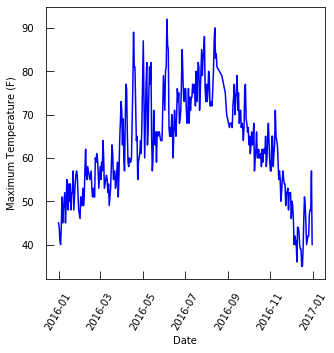

In [88]:
import datetime
feature_list=list(features.columns)
labels=features["actual"]
# Dates of training values
months = np.array(features)[:, feature_list.index('month')]
days = np.array(features)[:, feature_list.index('day')]
years = np.array(features)[:, feature_list.index('year')]

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})


plt.xlabel('Date'); 
plt.ylabel('Maximum Temperature (F)')

# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')
plt.xticks(rotation = '60');
plt.show()

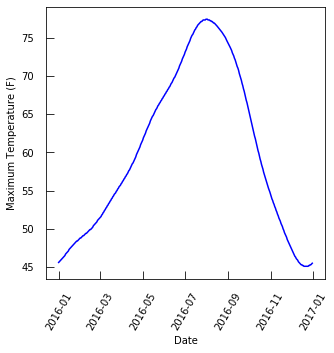

In [89]:
import datetime
feature_list=list(features.columns)
labels=features["average"]
# Dates of training values
months = np.array(features)[:, feature_list.index('month')]
days = np.array(features)[:, feature_list.index('day')]
years = np.array(features)[:, feature_list.index('year')]

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'average': labels})


plt.xlabel('Date'); 
plt.ylabel('Maximum Temperature (F)')

# Plot the average values
plt.plot(true_data['date'], true_data['average'], 'b-', label = 'average')
plt.xticks(rotation = '60');
plt.show()